<a href="https://colab.research.google.com/github/jmardan/sdpqpy/blob/master/The_bbest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

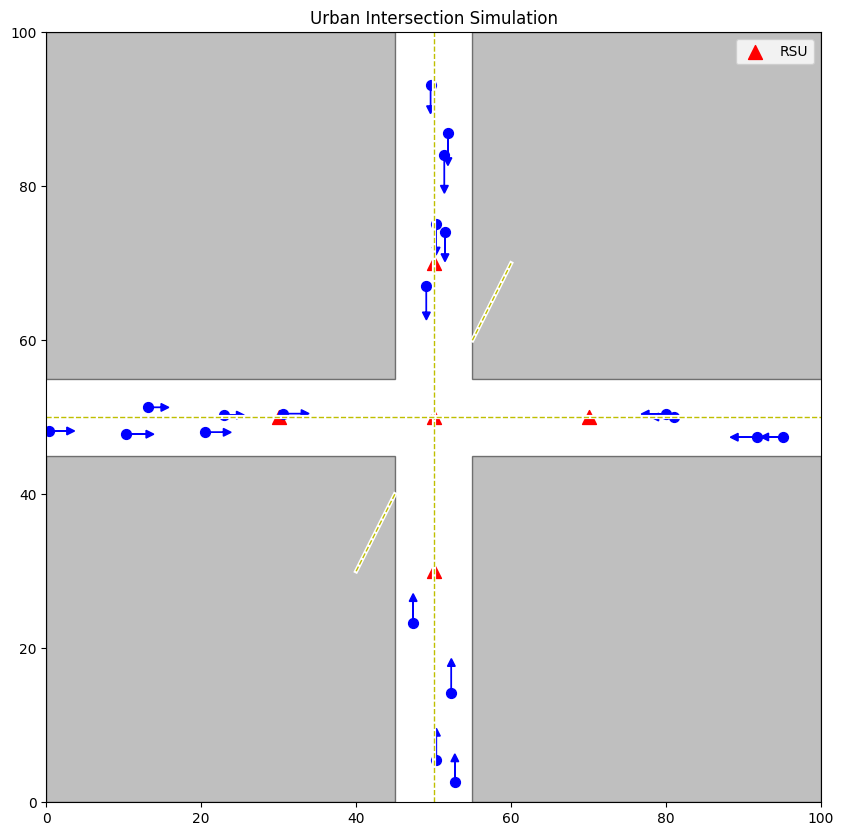

In [ ]:
import numpy as np
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt

class UrbanIntersection:
    def __init__(self, size=100):
        self.size = size
        self.buildings = self._create_buildings()
        self.roads = self._create_roads()
        self.rsu_positions = self._place_rsus()

    def _create_buildings(self):
        """Create four apartment blocks at intersection corners"""
        b_size = 20  # Building size
        offset = 5    # Distance from roads

        return [
            # NW Block
            Polygon([(0, self.size/2+offset), (0, self.size),
                    (self.size/2-offset, self.size), (self.size/2-offset, self.size/2+offset)]),
            # NE Block
            Polygon([(self.size/2+offset, self.size), (self.size, self.size),
                    (self.size, self.size/2+offset), (self.size/2+offset, self.size/2+offset)]),
            # SE Block
            Polygon([(self.size/2+offset, 0), (self.size, 0),
                    (self.size, self.size/2-offset), (self.size/2+offset, self.size/2-offset)]),
            # SW Block
            Polygon([(0, 0), (self.size/2-offset, 0),
                    (self.size/2-offset, self.size/2-offset), (0, self.size/2-offset)])
        ]

    def _create_roads(self):
        """Create crossing roads with acceleration/deceleration lanes"""
        main_width = 10
        lane_width = 5

        roads = [
            # Main NS Road
            LineString([(self.size/2, 0), (self.size/2, self.size)]),
            # Main EW Road
            LineString([(0, self.size/2), (self.size, self.size/2)]),

            # Acceleration/Deceleration lanes
            LineString([(self.size/2-main_width/2, self.size*0.4),
                       (self.size/2-main_width/2-lane_width, self.size*0.3)]),
            LineString([(self.size/2+main_width/2, self.size*0.6),
                       (self.size/2+main_width/2+lane_width, self.size*0.7)])
        ]
        return roads

    def _place_rsus(self):
        """Place RSUs at optimal locations along roads"""
        return np.array([
            [self.size/2, self.size/2],      # Center intersection
            [self.size/2, self.size*0.7],    # North approach
            [self.size/2, self.size*0.3],    # South approach
            [self.size*0.3, self.size/2],    # West approach
            [self.size*0.7, self.size/2]     # East approach
        ])

    def generate_traffic(self, num_vehicles=20):
        """Generate vehicles moving through intersection with realistic dynamics"""
        vehicles = []

        # NS direction vehicles (higher speed)
        for i in range(num_vehicles//2):
            if np.random.rand() > 0.5:  # Northbound
                pos = [self.size/2 + np.random.uniform(-3,3), np.random.uniform(0, self.size*0.4)]
                vel = [0, np.random.uniform(8,12)]  # 28-43 km/h
            else:  # Southbound
                pos = [self.size/2 + np.random.uniform(-3,3), np.random.uniform(self.size*0.6, self.size)]
                vel = [0, -np.random.uniform(8,12)]
            vehicles.append({'position': pos, 'velocity': vel})

        # EW direction vehicles
        for i in range(num_vehicles//2):
            if np.random.rand() > 0.5:  # Eastbound
                pos = [np.random.uniform(0, self.size*0.4), self.size/2 + np.random.uniform(-3,3)]
                vel = [np.random.uniform(5,8), 0]  # 18-28 km/h
            else:  # Westbound
                pos = [np.random.uniform(self.size*0.6, self.size), self.size/2 + np.random.uniform(-3,3)]
                vel = [-np.random.uniform(5,8), 0]
            vehicles.append({'position': pos, 'velocity': vel})

        return vehicles

    def visualize(self, vehicles=None):
        """Visualize the intersection with buildings, roads and RSUs"""
        plt.figure(figsize=(10,10))

        # Plot buildings
        for building in self.buildings:
            x,y = building.exterior.xy
            plt.fill(x,y, 'gray', alpha=0.5, edgecolor='black')

        # Plot roads
        for road in self.roads:
            x,y = road.xy
            plt.plot(x,y, 'w-', linewidth=3)
            plt.plot(x,y, 'y--', linewidth=1)  # Center lines

        # Plot RSUs
        rsu_x, rsu_y = self.rsu_positions.T
        plt.scatter(rsu_x, rsu_y, c='red', marker='^', s=100, label='RSU')

        # Plot vehicles
        if vehicles:
            for vehicle in vehicles:
                pos = vehicle['position']
                vel = vehicle['velocity']
                plt.scatter(pos[0], pos[1], c='blue', s=50)
                plt.arrow(pos[0], pos[1], vel[0]/3, vel[1]/3,
                         head_width=1, head_length=1, fc='blue', ec='blue')

        plt.xlim(0, self.size)
        plt.ylim(0, self.size)
        plt.title("Urban Intersection Simulation")
        plt.legend()
        plt.show()

# Create and visualize the intersection
intersection = UrbanIntersection()
vehicles = intersection.generate_traffic()
intersection.visualize(vehicles)

In [ ]:
!pip install torch_geometric

In [ ]:
import numpy as np
from shapely.geometry import Polygon, LineString
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class UrbanIntersection:
    def __init__(self, size=100):
        self.size = size  # Initialize size first
        self.buildings = self._create_buildings()
        self.roads = self._create_roads()
        self.rsu_positions = self._place_rsus()

    def _create_buildings(self):
        """Create four apartment blocks at intersection corners"""
        b_size = 20  # Building size
        offset = 5    # Distance from roads

        return [
            # NW Block
            Polygon([(0, self.size/2+offset), (0, self.size),
                    (self.size/2-offset, self.size), (self.size/2-offset, self.size/2+offset)]),
            # NE Block
            Polygon([(self.size/2+offset, self.size), (self.size, self.size),
                    (self.size, self.size/2+offset), (self.size/2+offset, self.size/2+offset)]),
            # SE Block
            Polygon([(self.size/2+offset, 0), (self.size, 0),
                    (self.size, self.size/2-offset), (self.size/2+offset, self.size/2-offset)]),
            # SW Block
            Polygon([(0, 0), (self.size/2-offset, 0),
                    (self.size/2-offset, self.size/2-offset), (0, self.size/2-offset)])
        ]

    def _create_roads(self):
        """Create crossing roads with acceleration/deceleration lanes"""
        main_width = 10
        lane_width = 5

        roads = [
            # Main NS Road
            LineString([(self.size/2, 0), (self.size/2, self.size)]),
            # Main EW Road
            LineString([(0, self.size/2), (self.size, self.size/2)]),

            # Acceleration/Deceleration lanes
            LineString([(self.size/2-main_width/2, self.size*0.4),
                       (self.size/2-main_width/2-lane_width, self.size*0.3)]),
            LineString([(self.size/2+main_width/2, self.size*0.6),
                       (self.size/2+main_width/2+lane_width, self.size*0.7)])
        ]
        return roads

    def _place_rsus(self):
        """Place RSUs at optimal locations along roads"""
        return np.array([
            [self.size/2, self.size/2],      # Center intersection
            [self.size/2, self.size*0.7],    # North approach
            [self.size/2, self.size*0.3],    # South approach
            [self.size*0.3, self.size/2],    # West approach
            [self.size*0.7, self.size/2]     # East approach
        ])

    def generate_traffic(self, num_vehicles=20):
        """Generate vehicles moving through intersection with realistic dynamics"""
        vehicles = []

        for _ in range(num_vehicles):
            if np.random.rand() > 0.5:  # NS vehicles
                if np.random.rand() > 0.5:  # Northbound
                    pos = np.array([self.size/2 + np.random.uniform(-3, 3),
                                   np.random.uniform(0, self.size*0.4)])
                    vel = np.array([0, np.random.uniform(8, 12)])  # 28-43 km/h
                else:  # Southbound
                    pos = np.array([self.size/2 + np.random.uniform(-3, 3),
                                   np.random.uniform(self.size*0.6, self.size)])
                    vel = np.array([0, -np.random.uniform(8, 12)])
            else:  # EW vehicles
                if np.random.rand() > 0.5:  # Eastbound
                    pos = np.array([np.random.uniform(0, self.size*0.4),
                                   self.size/2 + np.random.uniform(-3, 3)])
                    vel = np.array([np.random.uniform(5, 8), 0])  # 18-28 km/h
                else:  # Westbound
                    pos = np.array([np.random.uniform(self.size*0.6, self.size),
                                   self.size/2 + np.random.uniform(-3, 3)])
                    vel = np.array([-np.random.uniform(5, 8), 0])
            vehicles.append({'position': pos, 'velocity': vel})
        return vehicles

    def update_vehicles(self, vehicles):
        """Update vehicle positions based on velocity and handle boundary conditions"""
        updated_vehicles = []
        for vehicle in vehicles:
            pos = vehicle['position'] + vehicle['velocity'] * 0.1  # Small time step

            # Reset vehicles that go out of bounds
            if (pos[0] < 0 or pos[0] > self.size or
                pos[1] < 0 or pos[1] > self.size):
                # Re-spawn at a random edge
                edge = np.random.choice(['north', 'south', 'east', 'west'])
                if edge == 'north':
                    pos = np.array([self.size/2 + np.random.uniform(-3, 3),
                                   self.size - 1])
                    vel = np.array([0, -np.random.uniform(8, 12)])
                elif edge == 'south':
                    pos = np.array([self.size/2 + np.random.uniform(-3, 3), 1])
                    vel = np.array([0, np.random.uniform(8, 12)])
                elif edge == 'east':
                    pos = np.array([self.size - 1,
                                   self.size/2 + np.random.uniform(-3, 3)])
                    vel = np.array([-np.random.uniform(5, 8), 0])
                else:  # west
                    pos = np.array([1, self.size/2 + np.random.uniform(-3, 3)])
                    vel = np.array([np.random.uniform(5, 8), 0])
            else:
                vel = vehicle['velocity']

            updated_vehicles.append({'position': pos, 'velocity': vel})
        return updated_vehicles

    def animate(self, frames=100):
        """Create an animation of vehicles moving through the intersection"""
        fig, ax = plt.subplots(figsize=(10, 10))
        vehicles = self.generate_traffic()

        def init():
            """Initialize the plot with static elements"""
            ax.clear()
            # Plot buildings
            for building in self.buildings:
                x, y = building.exterior.xy
                ax.fill(x, y, 'gray', alpha=0.5, edgecolor='black')
            # Plot roads
            for road in self.roads:
                x, y = road.xy
                ax.plot(x, y, 'w-', linewidth=3)
                ax.plot(x, y, 'y--', linewidth=1)
            # Plot RSUs
            rsu_x, rsu_y = self.rsu_positions.T
            ax.scatter(rsu_x, rsu_y, c='red', marker='^', s=100, label='RSU')
            ax.set_xlim(0, self.size)
            ax.set_ylim(0, self.size)
            ax.set_title("Urban Intersection Simulation")
            ax.legend()
            return []

        def update(frame):
            """Update function for animation"""
            nonlocal vehicles
            ax.clear()

            # Re-draw static elements
            for building in self.buildings:
                x, y = building.exterior.xy
                ax.fill(x, y, 'gray', alpha=0.5, edgecolor='black')
            for road in self.roads:
                x, y = road.xy
                ax.plot(x, y, 'w-', linewidth=3)
                ax.plot(x, y, 'y--', linewidth=1)
            rsu_x, rsu_y = self.rsu_positions.T
            ax.scatter(rsu_x, rsu_y, c='red', marker='^', s=100, label='RSU')

            # Update and plot vehicles
            vehicles = self.update_vehicles(vehicles)
            for vehicle in vehicles:
                pos = vehicle['position']
                vel = vehicle['velocity']
                ax.scatter(pos[0], pos[1], c='blue', s=50)
                ax.arrow(pos[0], pos[1], vel[0]/3, vel[1]/3,
                        head_width=1, head_length=1, fc='blue', ec='blue')

            ax.set_xlim(0, self.size)
            ax.set_ylim(0, self.size)
            ax.set_title(f"Urban Intersection Simulation (Frame {frame+1}/{frames})")
            ax.legend()
            return []

        ani = FuncAnimation(fig, update, frames=frames, init_func=init,
                           interval=100, blit=False, repeat=True)
        plt.close()  # Prevents duplicate display in notebooks
        return ani

# Create and animate the intersection
intersection = UrbanIntersection()
ani = intersection.animate(frames=100)

# To display in Jupyter Notebook:
from IPython.display import HTML
HTML(ani.to_jshtml())

# To save as GIF (requires pillow):
# ani.save('intersection.gif', writer='pillow', fps=10)
plt.show()

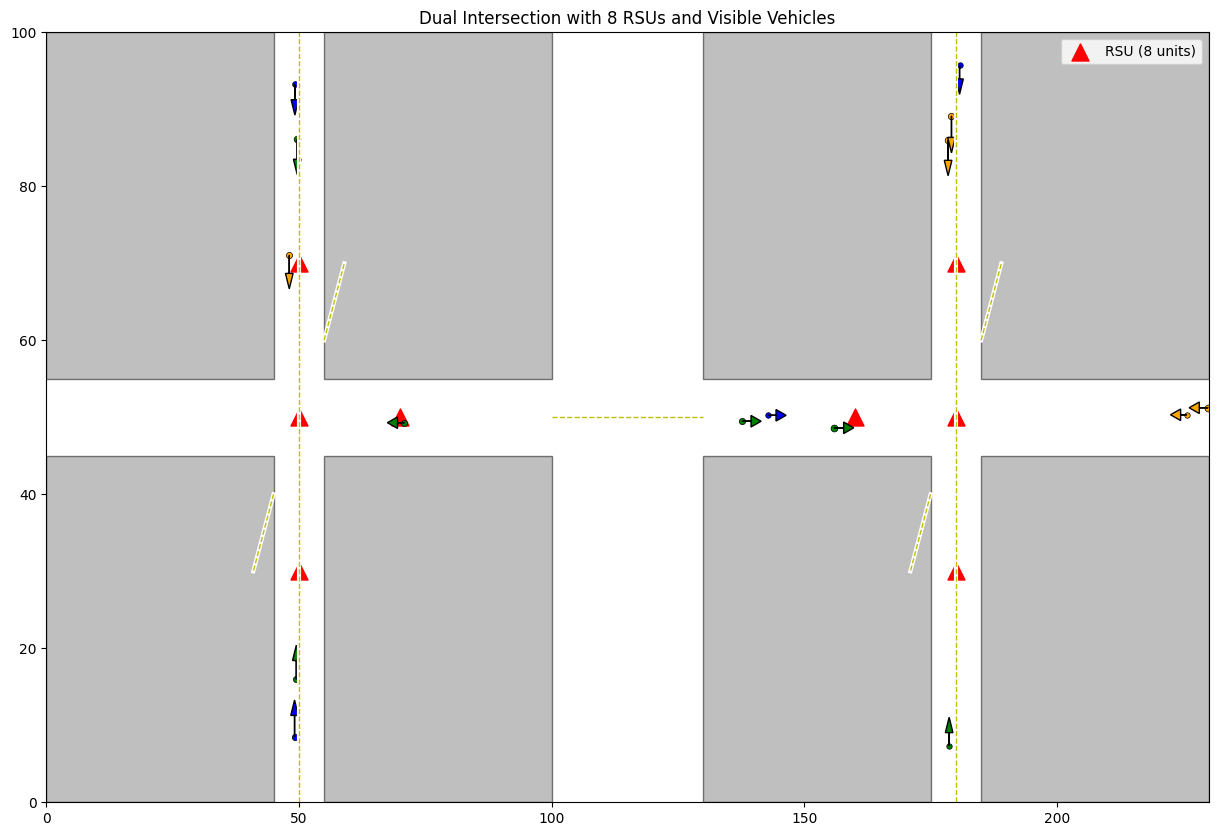

In [ ]:
import numpy as np
from shapely.geometry import Polygon, LineString
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

class DualIntersection:
    def __init__(self, size=100, spacing=30):
        self.size = size
        self.spacing = spacing
        self.buildings = self._create_buildings()
        self.roads = self._create_roads()
        self.rsu_positions = self._place_minimal_rsus()  # Reduced RSU count

    def _create_buildings(self):
        """Create smaller apartment blocks (15x15)"""
        b_size = 15
        offset = 5
        buildings = []

        # Left intersection buildings
        buildings.extend([
            Polygon([(0, self.size/2+offset), (0, self.size),
                   (self.size/2-offset, self.size), (self.size/2-offset, self.size/2+offset)]),  # NW
            Polygon([(self.size/2+offset, self.size), (self.size, self.size),
                   (self.size, self.size/2+offset), (self.size/2+offset, self.size/2+offset)]),  # NE
            Polygon([(self.size/2+offset, 0), (self.size, 0),
                   (self.size, self.size/2-offset), (self.size/2+offset, self.size/2-offset)]),  # SE
            Polygon([(0, 0), (self.size/2-offset, 0),
                   (self.size/2-offset, self.size/2-offset), (0, self.size/2-offset)])  # SW
        ])

        # Right intersection buildings (shifted by spacing)
        x_shift = self.size + self.spacing
        buildings.extend([
            Polygon([(x_shift, self.size/2+offset), (x_shift, self.size),
                    (x_shift+self.size/2-offset, self.size), (x_shift+self.size/2-offset, self.size/2+offset)]),  # NW
            Polygon([(x_shift+self.size/2+offset, self.size), (x_shift+self.size, self.size),
                    (x_shift+self.size, self.size/2+offset), (x_shift+self.size/2+offset, self.size/2+offset)]),  # NE
            Polygon([(x_shift+self.size/2+offset, 0), (x_shift+self.size, 0),
                    (x_shift+self.size, self.size/2-offset), (x_shift+self.size/2+offset, self.size/2-offset)]),  # SE
            Polygon([(x_shift, 0), (x_shift+self.size/2-offset, 0),
                    (x_shift+self.size/2-offset, self.size/2-offset), (x_shift, self.size/2-offset)])  # SW
        ])
        return buildings

    def _create_roads(self):
        """Create roads connecting two intersections"""
        main_width = 10
        lane_width = 4
        x_shift = self.size + self.spacing

        roads = [
            # Vertical roads
            LineString([(self.size/2, 0), (self.size/2, self.size)]),  # Left
            LineString([(x_shift+self.size/2, 0), (x_shift+self.size/2, self.size)]),  # Right

            # Horizontal connecting road
            LineString([(self.size, self.size/2), (x_shift, self.size/2)]),

            # Left intersection lanes
            LineString([(self.size/2-main_width/2, self.size*0.4),
                       (self.size/2-main_width/2-lane_width, self.size*0.3)]),  # Deceleration
            LineString([(self.size/2+main_width/2, self.size*0.6),
                       (self.size/2+main_width/2+lane_width, self.size*0.7)]),  # Acceleration

            # Right intersection lanes
            LineString([(x_shift+self.size/2-main_width/2, self.size*0.4),
                       (x_shift+self.size/2-main_width/2-lane_width, self.size*0.3)]),
            LineString([(x_shift+self.size/2+main_width/2, self.size*0.6),
                       (x_shift+self.size/2+main_width/2+lane_width, self.size*0.7)])
        ]
        return roads

    def _place_minimal_rsus(self):
        """Place only 8 essential RSUs (4 per intersection)"""
        x_shift = self.size + self.spacing
        return np.array([
            # Left intersection
            [self.size/2, self.size/2],      # Center
            [self.size/2, self.size*0.7],    # North approach
            [self.size/2, self.size*0.3],    # South approach
            [self.size*0.7, self.size/2],    # East approach

            # Right intersection
            [x_shift+self.size/2, self.size/2],      # Center
            [x_shift+self.size/2, self.size*0.7],    # North approach
            [x_shift+self.size/2, self.size*0.3],    # South approach
            [x_shift+self.size*0.3, self.size/2]     # West approach
        ])

    def generate_traffic(self, num_vehicles=20):
        """Generate vehicles with clearer visibility"""
        vehicles = []
        x_shift = self.size + self.spacing

        for _ in range(num_vehicles):
            # Make vehicles larger and more visible
            size = np.random.uniform(1.5, 2.5)  # Size multiplier

            if np.random.rand() > 0.5:  # Left intersection
                if np.random.rand() > 0.5:  # Vertical
                    if np.random.rand() > 0.5:  # Northbound
                        pos = np.array([self.size/2 + np.random.uniform(-2, 2),
                                       np.random.uniform(0, self.size*0.3)])
                        vel = np.array([0, np.random.uniform(5, 7)]) * size
                    else:  # Southbound
                        pos = np.array([self.size/2 + np.random.uniform(-2, 2),
                                       np.random.uniform(self.size*0.7, self.size)])
                        vel = np.array([0, -np.random.uniform(5, 7)]) * size
                else:  # Horizontal
                    if np.random.rand() > 0.5:  # Eastbound
                        pos = np.array([np.random.uniform(0, self.size*0.3),
                                       self.size/2 + np.random.uniform(-2, 2)])
                        vel = np.array([np.random.uniform(3, 5), 0]) * size
                    else:  # Westbound
                        pos = np.array([np.random.uniform(self.size*0.7, self.size),
                                       self.size/2 + np.random.uniform(-2, 2)])
                        vel = np.array([-np.random.uniform(3, 5), 0]) * size
            else:  # Right intersection
                if np.random.rand() > 0.5:  # Vertical
                    if np.random.rand() > 0.5:  # Northbound
                        pos = np.array([x_shift+self.size/2 + np.random.uniform(-2, 2),
                                       np.random.uniform(0, self.size*0.3)])
                        vel = np.array([0, np.random.uniform(5, 7)]) * size
                    else:  # Southbound
                        pos = np.array([x_shift+self.size/2 + np.random.uniform(-2, 2),
                                       np.random.uniform(self.size*0.7, self.size)])
                        vel = np.array([0, -np.random.uniform(5, 7)]) * size
                else:  # Horizontal
                    if np.random.rand() > 0.5:  # Eastbound
                        pos = np.array([x_shift + np.random.uniform(0, self.size*0.3),
                                       self.size/2 + np.random.uniform(-2, 2)])
                        vel = np.array([np.random.uniform(3, 5), 0]) * size
                    else:  # Westbound
                        pos = np.array([x_shift + np.random.uniform(self.size*0.7, self.size),
                                       self.size/2 + np.random.uniform(-2, 2)])
                        vel = np.array([-np.random.uniform(3, 5), 0]) * size

            vehicles.append({
                'position': pos,
                'velocity': vel,
                'size': 10 * size,  # Larger vehicles
                'color': np.random.choice(['blue', 'green', 'orange'])  # Color variation
            })
        return vehicles

    def update_vehicles(self, vehicles):
        """Update positions with boundary checks"""
        updated_vehicles = []
        x_shift = self.size + self.spacing

        for vehicle in vehicles:
            pos = vehicle['position'] + vehicle['velocity'] * 0.1
            vel = vehicle['velocity'].copy()

            # Boundary checks
            if pos[0] < 0 or pos[0] > x_shift + self.size or pos[1] < 0 or pos[1] > self.size:
                # Respawn at random edge
                edge = np.random.choice(['north', 'south', 'east', 'west'])
                if edge == 'north':
                    pos = np.array([np.random.uniform(0, x_shift + self.size), self.size - 1])
                    vel = np.array([0, -np.random.uniform(5, 7)])
                elif edge == 'south':
                    pos = np.array([np.random.uniform(0, x_shift + self.size), 1])
                    vel = np.array([0, np.random.uniform(5, 7)])
                elif edge == 'east':
                    pos = np.array([x_shift + self.size - 1, np.random.uniform(0, self.size)])
                    vel = np.array([-np.random.uniform(3, 5), 0])
                else:  # west
                    pos = np.array([1, np.random.uniform(0, self.size)])
                    vel = np.array([np.random.uniform(3, 5), 0])

            updated_vehicles.append({
                'position': pos,
                'velocity': vel,
                'size': vehicle['size'],
                'color': vehicle['color']
            })
        return updated_vehicles

    def visualize(self):
        """Static visualization with vehicles"""
        plt.figure(figsize=(15, 10))

        # Buildings
        for building in self.buildings:
            x, y = building.exterior.xy
            plt.fill(x, y, 'gray', alpha=0.5, edgecolor='black')

        # Roads
        for road in self.roads:
            x, y = road.xy
            plt.plot(x, y, 'w-', linewidth=3)
            plt.plot(x, y, 'y--', linewidth=1)

        # RSUs (8 total)
        plt.scatter(self.rsu_positions[:, 0], self.rsu_positions[:, 1],
                  c='red', marker='^', s=150, label='RSU (8 units)')

        # Sample vehicles (static)
        vehicles = self.generate_traffic(15)  # Fewer vehicles for clarity
        for vehicle in vehicles:
            plt.scatter(vehicle['position'][0], vehicle['position'][1],
                       c=vehicle['color'], s=vehicle['size'],
                       edgecolor='black', linewidth=0.5)
            plt.arrow(vehicle['position'][0], vehicle['position'][1],
                     vehicle['velocity'][0]/5, vehicle['velocity'][1]/5,
                     head_width=1.5, head_length=2, fc=vehicle['color'], ec='black')

        plt.xlim(0, self.size * 2 + self.spacing)
        plt.ylim(0, self.size)
        plt.title("Dual Intersection with 8 RSUs and Visible Vehicles")
        plt.legend()
        plt.show()

    def animate(self, frames=50):
        """Animate with clear vehicles"""
        fig, ax = plt.subplots(figsize=(15, 10))
        vehicles = self.generate_traffic(15)  # Fewer vehicles for better visibility

        def init():
            ax.clear()
            # Buildings
            for building in self.buildings:
                x, y = building.exterior.xy
                ax.fill(x, y, 'gray', alpha=0.5, edgecolor='black')
            # Roads
            for road in self.roads:
                x, y = road.xy
                ax.plot(x, y, 'w-', linewidth=3)
                ax.plot(x, y, 'y--', linewidth=1)
            # RSUs
            ax.scatter(self.rsu_positions[:, 0], self.rsu_positions[:, 1],
                      c='red', marker='^', s=150, label='RSU')
            ax.set_xlim(0, self.size * 2 + self.spacing)
            ax.set_ylim(0, self.size)
            ax.set_title("Dual Intersection Traffic Simulation")
            ax.legend()
            return []

        def update(frame):
            nonlocal vehicles
            ax.clear()

            # Static elements
            for building in self.buildings:
                x, y = building.exterior.xy
                ax.fill(x, y, 'gray', alpha=0.5, edgecolor='black')
            for road in self.roads:
                x, y = road.xy
                ax.plot(x, y, 'w-', linewidth=3)
                ax.plot(x, y, 'y--', linewidth=1)
            ax.scatter(self.rsu_positions[:, 0], self.rsu_positions[:, 1],
                      c='red', marker='^', s=150, label='RSU')

            # Vehicles
            vehicles = self.update_vehicles(vehicles)
            for vehicle in vehicles:
                ax.scatter(vehicle['position'][0], vehicle['position'][1],
                         c=vehicle['color'], s=vehicle['size'],
                         edgecolor='black', linewidth=0.5)
                ax.arrow(vehicle['position'][0], vehicle['position'][1],
                        vehicle['velocity'][0]/5, vehicle['velocity'][1]/5,
                        head_width=1.5, head_length=2, fc=vehicle['color'], ec='black')

            ax.set_xlim(0, self.size * 2 + self.spacing)
            ax.set_ylim(0, self.size)
            ax.set_title(f"Frame {frame+1}/{frames} - Vehicles in Motion")
            ax.legend()
            return []

        ani = FuncAnimation(fig, update, frames=frames, init_func=init,
                          interval=150, blit=False)
        plt.close()
        return ani

# Run in Colab
sim = DualIntersection(size=100, spacing=30)
sim.visualize()  # Static view with vehicles

# For animation (uncomment to run)
# ani = sim.animate(frames=50)
# display(HTML(ani.to_jshtml()))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
import numpy as np
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment
from scipy.signal import find_peaks
from shapely.geometry import LineString, Polygon, Point, MultiPoint
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from typing import List, Dict, Optional
from collections import defaultdict

# Physical Constants with Urban Propagation Parameters
RSU_BAND_FREQUENCY_HZ = 5.9e9  # 5.9 GHz (DSRC band)
SPEED_OF_LIGHT = 3e8
WAVELENGTH = SPEED_OF_LIGHT / RSU_BAND_FREQUENCY_HZ
PATH_LOSS_EXPONENT = 3.0  # Typical for urban environments
SHADOWING_STD_DEV = 8  # dB for urban areas
MAX_VELOCITY = 33.3  # m/s (~120 km/h)
OTFS_GRID_SIZE = (128, 128)  # delay x Doppler
MIN_VEHICLE_SPACING = 3.0  # meters between vehicles
BUILDING_CLEARANCE = 10.0  # meters around buildings
MAX_RANGE = 300  # meters (adjusted for urban propagation)

class UrbanEnvironment:
    def __init__(self, size=100, spacing=30):
        self.size = size
        self.spacing = spacing
        self.area_size = size * 2 + spacing
        self.intersection = DualIntersection(size, spacing)

        # Urban material properties
        self.material_properties = {
            'concrete': {'reflection': 0.4, 'diffusion': 0.6, 'penetration_loss': 15},
            'glass': {'reflection': 0.7, 'diffusion': 0.3, 'penetration_loss': 5},
            'metal': {'reflection': 0.9, 'diffusion': 0.1, 'penetration_loss': 30}
        }

    def is_valid_position(self, pos):
        """Check if position is in navigable space (on roads)"""
        point = Point(pos)
        for road in self.intersection.roads:
            if road.distance(point) < BUILDING_CLEARANCE:
                return True
        return False

    def _is_blocked(self, p1, p2):
        """Check if line between points intersects any building"""
        line = LineString([p1, p2])
        for building in self.intersection.buildings:
            if building.intersects(line):
                return True, building
        return False, None

    def generate_scene(self, num_targets=8):
        """Generate urban scenario with realistic vehicle placement"""
        vehicles = self.intersection.generate_traffic(num_targets)
        target_pos = np.array([v['position'] for v in vehicles])
        target_vel = np.array([v['velocity'] for v in vehicles])
        rsu_pos = self.intersection.rsu_positions
        return target_pos, target_vel, rsu_pos

    def visualize_scene(self):
        """Visualize the urban environment"""
        self.intersection.visualize()

class OTFSChannelModel:
    def __init__(self, env: UrbanEnvironment):
        self.env = env
        self.delay_resolution = MAX_RANGE / OTFS_GRID_SIZE[0]
        self.doppler_resolution = 2*MAX_VELOCITY / OTFS_GRID_SIZE[1]
        self.reference_distance = 10  # meters for path loss model
        self.reference_loss = 20 * np.log10(4 * np.pi * self.reference_distance / WAVELENGTH)

    def _urban_path_loss(self, distance):
        """Urban path loss model with shadowing"""
        if distance == 0:
            return 0
        path_loss = self.reference_loss + 10 * PATH_LOSS_EXPONENT * np.log10(distance/self.reference_distance)
        shadowing = np.random.normal(0, SHADOWING_STD_DEV)
        return path_loss + shadowing

    def _calculate_doppler(self, target_pos, target_vel, rx_pos):
        """Calculate Doppler shift including urban multipath effects"""
        unit_vec = (target_pos - rx_pos) / (np.linalg.norm(target_pos - rx_pos) + 1e-6)
        return 2 * np.dot(target_vel, unit_vec) * RSU_BAND_FREQUENCY_HZ / SPEED_OF_LIGHT

    def _find_reflection(self, tx_pos, rx_pos, building):
        """Find reflection points with material properties"""
        tx_point, rx_point = Point(tx_pos), Point(rx_pos)
        tx_rx_line = LineString([tx_point, rx_point])

        if not building.exterior.intersects(tx_rx_line):
            return None

        intersection = building.exterior.intersection(tx_rx_line)
        if intersection.is_empty:
            return None

        if isinstance(intersection, MultiPoint):
            intersection = intersection[0]

        return np.array([intersection.x, intersection.y])

    def generate_channel_response(self, tx_pos, rx_pos, target_pos, target_vel):
        """Generate OTFS channel response with urban propagation effects"""
        channel_grid = np.zeros(OTFS_GRID_SIZE)

        # Direct path (if exists)
        blocked, _ = self.env._is_blocked(tx_pos, target_pos)
        if not blocked and not self.env._is_blocked(target_pos, rx_pos)[0]:
            distance = np.linalg.norm(tx_pos - target_pos) + np.linalg.norm(target_pos - rx_pos)
            path_loss = self._urban_path_loss(distance)
            self._add_path_to_grid(channel_grid, distance, target_pos, target_vel, rx_pos,
                                  is_direct=True, path_loss=path_loss)

        # Reflected paths (up to 2 bounces)
        for building in self.env.intersection.buildings:
            reflection_point = self._find_reflection(tx_pos, rx_pos, building)
            if reflection_point is not None:
                blocked1 = self.env._is_blocked(reflection_point, rx_pos)[0]
                blocked2 = self.env._is_blocked(tx_pos, reflection_point)[0]
                if not blocked1 and not blocked2:
                    distance = (np.linalg.norm(tx_pos - reflection_point) +
                              np.linalg.norm(reflection_point - target_pos) +
                              np.linalg.norm(target_pos - rx_pos))
                    path_loss = self._urban_path_loss(distance)
                    material_loss = self.env.material_properties['concrete']['reflection']
                    self._add_path_to_grid(channel_grid, distance, target_pos, target_vel,
                                         reflection_point, is_direct=False,
                                         path_loss=path_loss + material_loss)

        return channel_grid

    def _add_path_to_grid(self, grid, distance, target_pos, target_vel, interaction_point,
                         is_direct, path_loss):
        """Add propagation path to OTFS grid with urban propagation effects"""
        if distance > MAX_RANGE:
            return

        delay = distance / SPEED_OF_LIGHT
        doppler = self._calculate_doppler(target_pos, target_vel, interaction_point)

        # Convert path loss to power (dBm to linear)
        power = 10**((30 - path_loss)/10)  # Assume 30 dBm transmit power

        delay_bin = min(int(delay / self.delay_resolution), OTFS_GRID_SIZE[0]-1)
        doppler_bin = min(int((doppler + MAX_VELOCITY) / (2*MAX_VELOCITY) * OTFS_GRID_SIZE[1]),
                        OTFS_GRID_SIZE[1]-1)

        if delay_bin >= 0 and doppler_bin >= 0:
            grid[delay_bin, doppler_bin] += power

class OTFSMeasurementGenerator:
    def __init__(self, env: UrbanEnvironment, snr_db=20, augment=True):
        self.env = env
        self.snr = 10**(snr_db/10)
        self.channel_model = OTFSChannelModel(env)
        self.augment = augment

    def generate_measurements(self, rsu_pos, target_pos, target_vel):
        measurements = []
        for rsu_idx, rsu_p in enumerate(rsu_pos):
            channel_response = np.zeros(OTFS_GRID_SIZE)
            for t_idx, (t_pos, t_vel) in enumerate(zip(target_pos, target_vel)):
                channel_response += self.channel_model.generate_channel_response(
                    rsu_p, rsu_p, t_pos, t_vel)

            # Add noise based on SNR and urban interference
            noise_power = np.max(channel_response) / self.snr
            noisy_response = channel_response + np.random.normal(0, np.sqrt(noise_power), OTFS_GRID_SIZE)

            # Detect peaks with urban-adaptive threshold
            threshold = 0.1 * np.max(noisy_response)
            peaks, _ = find_peaks(noisy_response.flatten(), height=threshold)

            for peak in peaks:
                delay_bin, doppler_bin = np.unravel_index(peak, OTFS_GRID_SIZE)
                measurements.append({
                    'rsu_idx': rsu_idx,
                    'rsu_pos': rsu_p,
                    'delay': delay_bin * self.channel_model.delay_resolution,
                    'doppler': doppler_bin * self.channel_model.doppler_resolution - MAX_VELOCITY,
                    'theta': np.random.uniform(-np.pi, np.pi),
                    'power': noisy_response[delay_bin, doppler_bin]
                })

        if self.augment:
            # Urban-specific augmentation
            for m in measurements:
                # Add urban multipath effects
                m['power'] *= np.random.uniform(0.7, 1.3)
                # Add urban angle spread
                m['theta'] += np.random.normal(0, 0.15)
        return measurements

# [Rest of the code (EnhancedGNN, ISACTrainer classes) remains the same...]


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00


Starting training with dual intersection environment...


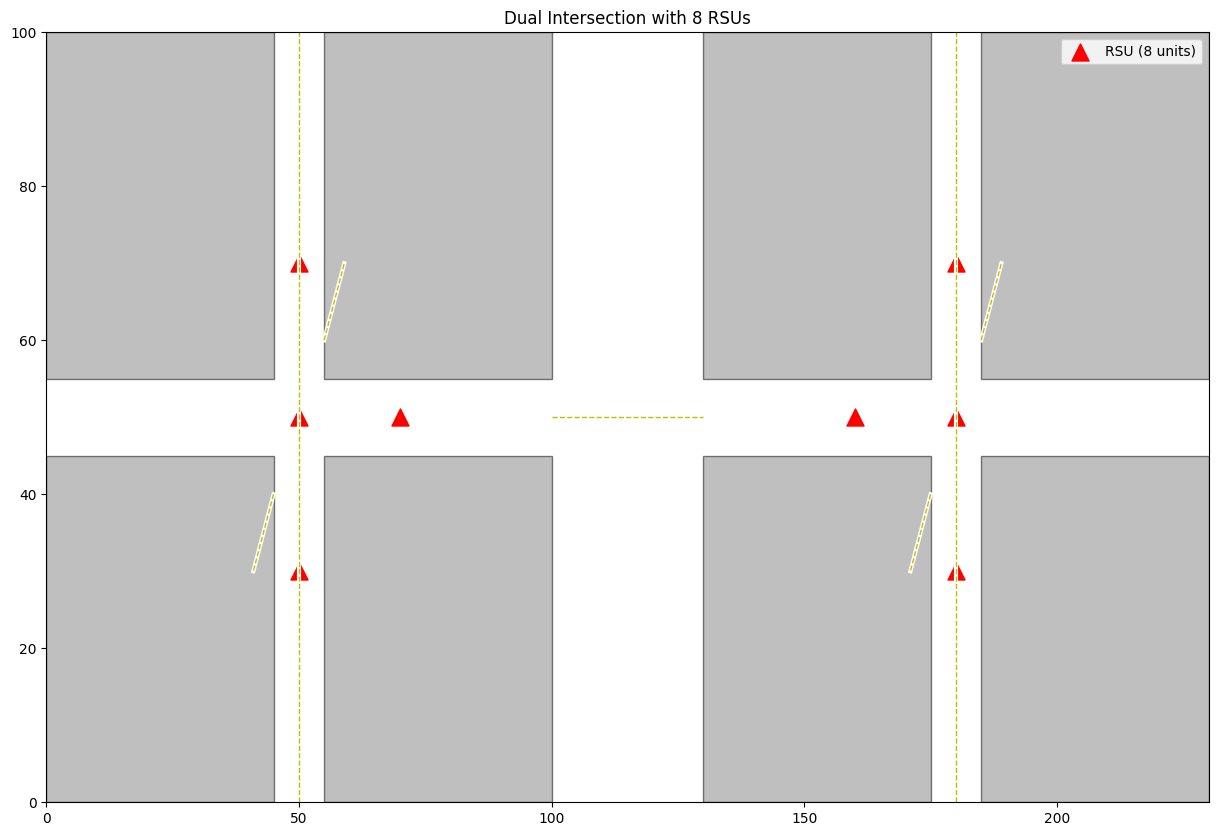

Epoch 0: Train Pos RMSE = 6.84 cm | Train Vel RMSE = 1.84 m/s | Val Pos RMSE = 7.66 cm | Val Vel RMSE = 2.74 m/s | Match Rate = 32.8%
Epoch 2: Train Pos RMSE = 6.68 cm | Train Vel RMSE = 1.95 m/s | Val Pos RMSE = 7.69 cm | Val Vel RMSE = 1.83 m/s | Match Rate = 33.3%
Epoch 4: Train Pos RMSE = 5.99 cm | Train Vel RMSE = 1.76 m/s | Val Pos RMSE = 7.97 cm | Val Vel RMSE = 1.72 m/s | Match Rate = 34.3%
Epoch 6: Train Pos RMSE = 6.61 cm | Train Vel RMSE = 1.91 m/s | Val Pos RMSE = 7.82 cm | Val Vel RMSE = 1.60 m/s | Match Rate = 34.1%


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
import numpy as np
from scipy.spatial import Delaunay, distance_matrix
from scipy.optimize import linear_sum_assignment
from scipy.signal import find_peaks
from shapely.geometry import LineString, Polygon, Point, MultiPoint
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from typing import List, Dict, Optional
from collections import defaultdict

# Physical Constants
RSU_BAND_FREQUENCY_HZ = 5.9e9  # 5.9 GHz
SPEED_OF_LIGHT = 3e8
MAX_RANGE = 200  # meters
MAX_VELOCITY = 33.3  # m/s
OTFS_GRID_SIZE = (128, 128)  # delay x Doppler
MIN_VEHICLE_SPACING = 3.0  # meters between vehicles
BUILDING_CLEARANCE = 10.0  # meters around buildings

class DualIntersection:
    def __init__(self, size=100, spacing=30):
        self.size = size
        self.spacing = spacing
        self.buildings = self._create_buildings()
        self.roads = self._create_roads()
        self.rsu_positions = self._place_minimal_rsus()  # Reduced RSU count

    def _create_buildings(self):
        """Create smaller apartment blocks (15x15)"""
        b_size = 15
        offset = 5
        buildings = []

        # Left intersection buildings
        buildings.extend([
            Polygon([(0, self.size/2+offset), (0, self.size),
                   (self.size/2-offset, self.size), (self.size/2-offset, self.size/2+offset)]),  # NW
            Polygon([(self.size/2+offset, self.size), (self.size, self.size),
                   (self.size, self.size/2+offset), (self.size/2+offset, self.size/2+offset)]),  # NE
            Polygon([(self.size/2+offset, 0), (self.size, 0),
                   (self.size, self.size/2-offset), (self.size/2+offset, self.size/2-offset)]),  # SE
            Polygon([(0, 0), (self.size/2-offset, 0),
                   (self.size/2-offset, self.size/2-offset), (0, self.size/2-offset)])  # SW
        ])

        # Right intersection buildings (shifted by spacing)
        x_shift = self.size + self.spacing
        buildings.extend([
            Polygon([(x_shift, self.size/2+offset), (x_shift, self.size),
                    (x_shift+self.size/2-offset, self.size), (x_shift+self.size/2-offset, self.size/2+offset)]),  # NW
            Polygon([(x_shift+self.size/2+offset, self.size), (x_shift+self.size, self.size),
                    (x_shift+self.size, self.size/2+offset), (x_shift+self.size/2+offset, self.size/2+offset)]),  # NE
            Polygon([(x_shift+self.size/2+offset, 0), (x_shift+self.size, 0),
                    (x_shift+self.size, self.size/2-offset), (x_shift+self.size/2+offset, self.size/2-offset)]),  # SE
            Polygon([(x_shift, 0), (x_shift+self.size/2-offset, 0),
                    (x_shift+self.size/2-offset, self.size/2-offset), (x_shift, self.size/2-offset)])  # SW
        ])
        return buildings

    def _create_roads(self):
        """Create roads connecting two intersections"""
        main_width = 10
        lane_width = 4
        x_shift = self.size + self.spacing

        roads = [
            # Vertical roads
            LineString([(self.size/2, 0), (self.size/2, self.size)]),  # Left
            LineString([(x_shift+self.size/2, 0), (x_shift+self.size/2, self.size)]),  # Right

            # Horizontal connecting road
            LineString([(self.size, self.size/2), (x_shift, self.size/2)]),

            # Left intersection lanes
            LineString([(self.size/2-main_width/2, self.size*0.4),
                       (self.size/2-main_width/2-lane_width, self.size*0.3)]),  # Deceleration
            LineString([(self.size/2+main_width/2, self.size*0.6),
                       (self.size/2+main_width/2+lane_width, self.size*0.7)]),  # Acceleration

            # Right intersection lanes
            LineString([(x_shift+self.size/2-main_width/2, self.size*0.4),
                       (x_shift+self.size/2-main_width/2-lane_width, self.size*0.3)]),
            LineString([(x_shift+self.size/2+main_width/2, self.size*0.6),
                       (x_shift+self.size/2+main_width/2+lane_width, self.size*0.7)])
        ]
        return roads

    def _place_minimal_rsus(self):
        """Place only 8 essential RSUs (4 per intersection)"""
        x_shift = self.size + self.spacing
        return np.array([
            # Left intersection
            [self.size/2, self.size/2],      # Center
            [self.size/2, self.size*0.7],    # North approach
            [self.size/2, self.size*0.3],    # South approach
            [self.size*0.7, self.size/2],    # East approach

            # Right intersection
            [x_shift+self.size/2, self.size/2],      # Center
            [x_shift+self.size/2, self.size*0.7],    # North approach
            [x_shift+self.size/2, self.size*0.3],    # South approach
            [x_shift+self.size*0.3, self.size/2]     # West approach
        ])

    def generate_traffic(self, num_vehicles=20):
        """Generate vehicles with clearer visibility"""
        vehicles = []
        x_shift = self.size + self.spacing

        for _ in range(num_vehicles):
            # Make vehicles larger and more visible
            size = np.random.uniform(1.5, 2.5)  # Size multiplier

            if np.random.rand() > 0.5:  # Left intersection
                if np.random.rand() > 0.5:  # Vertical
                    if np.random.rand() > 0.5:  # Northbound
                        pos = np.array([self.size/2 + np.random.uniform(-2, 2),
                                       np.random.uniform(0, self.size*0.3)])
                        vel = np.array([0, np.random.uniform(5, 7)]) * size
                    else:  # Southbound
                        pos = np.array([self.size/2 + np.random.uniform(-2, 2),
                                       np.random.uniform(self.size*0.7, self.size)])
                        vel = np.array([0, -np.random.uniform(5, 7)]) * size
                else:  # Horizontal
                    if np.random.rand() > 0.5:  # Eastbound
                        pos = np.array([np.random.uniform(0, self.size*0.3),
                                       self.size/2 + np.random.uniform(-2, 2)])
                        vel = np.array([np.random.uniform(3, 5), 0]) * size
                    else:  # Westbound
                        pos = np.array([np.random.uniform(self.size*0.7, self.size),
                                       self.size/2 + np.random.uniform(-2, 2)])
                        vel = np.array([-np.random.uniform(3, 5), 0]) * size
            else:  # Right intersection
                if np.random.rand() > 0.5:  # Vertical
                    if np.random.rand() > 0.5:  # Northbound
                        pos = np.array([x_shift+self.size/2 + np.random.uniform(-2, 2),
                                       np.random.uniform(0, self.size*0.3)])
                        vel = np.array([0, np.random.uniform(5, 7)]) * size
                    else:  # Southbound
                        pos = np.array([x_shift+self.size/2 + np.random.uniform(-2, 2),
                                       np.random.uniform(self.size*0.7, self.size)])
                        vel = np.array([0, -np.random.uniform(5, 7)]) * size
                else:  # Horizontal
                    if np.random.rand() > 0.5:  # Eastbound
                        pos = np.array([x_shift + np.random.uniform(0, self.size*0.3),
                                       self.size/2 + np.random.uniform(-2, 2)])
                        vel = np.array([np.random.uniform(3, 5), 0]) * size
                    else:  # Westbound
                        pos = np.array([x_shift + np.random.uniform(self.size*0.7, self.size),
                                       self.size/2 + np.random.uniform(-2, 2)])
                        vel = np.array([-np.random.uniform(3, 5), 0]) * size

            vehicles.append({
                'position': pos,
                'velocity': vel,
                'size': 10 * size,  # Larger vehicles
                'color': np.random.choice(['blue', 'green', 'orange'])  # Color variation
            })
        return vehicles

    def update_vehicles(self, vehicles):
        """Update positions with boundary checks"""
        updated_vehicles = []
        x_shift = self.size + self.spacing

        for vehicle in vehicles:
            pos = vehicle['position'] + vehicle['velocity'] * 0.1
            vel = vehicle['velocity'].copy()

            # Boundary checks
            if pos[0] < 0 or pos[0] > x_shift + self.size or pos[1] < 0 or pos[1] > self.size:
                # Respawn at random edge
                edge = np.random.choice(['north', 'south', 'east', 'west'])
                if edge == 'north':
                    pos = np.array([np.random.uniform(0, x_shift + self.size), self.size - 1])
                    vel = np.array([0, -np.random.uniform(5, 7)])
                elif edge == 'south':
                    pos = np.array([np.random.uniform(0, x_shift + self.size), 1])
                    vel = np.array([0, np.random.uniform(5, 7)])
                elif edge == 'east':
                    pos = np.array([x_shift + self.size - 1, np.random.uniform(0, self.size)])
                    vel = np.array([-np.random.uniform(3, 5), 0])
                else:  # west
                    pos = np.array([1, np.random.uniform(0, self.size)])
                    vel = np.array([np.random.uniform(3, 5), 0])

            updated_vehicles.append({
                'position': pos,
                'velocity': vel,
                'size': vehicle['size'],
                'color': vehicle['color']
            })
        return updated_vehicles

    def visualize(self, vehicles=None):
        """Static visualization with vehicles"""
        plt.figure(figsize=(15, 10))

        # Buildings
        for building in self.buildings:
            x, y = building.exterior.xy
            plt.fill(x, y, 'gray', alpha=0.5, edgecolor='black')

        # Roads
        for road in self.roads:
            x, y = road.xy
            plt.plot(x, y, 'w-', linewidth=3)
            plt.plot(x, y, 'y--', linewidth=1)

        # RSUs (8 total)
        plt.scatter(self.rsu_positions[:, 0], self.rsu_positions[:, 1],
                  c='red', marker='^', s=150, label='RSU (8 units)')

        # Plot vehicles if provided
        if vehicles:
            for vehicle in vehicles:
                plt.scatter(vehicle['position'][0], vehicle['position'][1],
                           c=vehicle['color'], s=vehicle['size'],
                           edgecolor='black', linewidth=0.5)
                plt.arrow(vehicle['position'][0], vehicle['position'][1],
                         vehicle['velocity'][0]/5, vehicle['velocity'][1]/5,
                         head_width=1.5, head_length=2, fc=vehicle['color'], ec='black')

        plt.xlim(0, self.size * 2 + self.spacing)
        plt.ylim(0, self.size)
        plt.title("Dual Intersection with 8 RSUs")
        plt.legend()
        plt.show()

class OTFSChannelModel:
    def __init__(self, env: DualIntersection):
        self.env = env
        self.delay_resolution = MAX_RANGE / OTFS_GRID_SIZE[0]
        self.doppler_resolution = 2*MAX_VELOCITY / OTFS_GRID_SIZE[1]

    def _free_space_path_loss(self, distance):
        lambda_ = SPEED_OF_LIGHT / RSU_BAND_FREQUENCY_HZ
        return (lambda_ / (4 * np.pi * distance))**2

    def _calculate_doppler(self, target_pos, target_vel, rx_pos):
        unit_vec = (target_pos - rx_pos) / (np.linalg.norm(target_pos - rx_pos) + 1e-6)
        return 2 * np.dot(target_vel, unit_vec) * RSU_BAND_FREQUENCY_HZ / SPEED_OF_LIGHT

    def _find_reflection(self, tx_pos, rx_pos, building):
        """Enhanced reflection finding with multiple bounce paths"""
        tx_point, rx_point = Point(tx_pos), Point(rx_pos)
        tx_rx_line = LineString([tx_point, rx_point])

        if not building.exterior.intersects(tx_rx_line):
            return None

        intersection = building.exterior.intersection(tx_rx_line)
        if intersection.is_empty:
            return None

        if isinstance(intersection, MultiPoint):
            return np.array([intersection[0].x, intersection[0].y])  # First intersection

        return np.array([intersection.x, intersection.y])

    def generate_channel_response(self, tx_pos, rx_pos, target_pos, target_vel):
        channel_grid = np.zeros(OTFS_GRID_SIZE)

        # Direct path
        if not self._is_blocked(tx_pos, target_pos) and not self._is_blocked(target_pos, rx_pos):
            distance = np.linalg.norm(tx_pos - target_pos) + np.linalg.norm(target_pos - rx_pos)
            self._add_path_to_grid(channel_grid, distance, target_pos, target_vel, rx_pos, is_direct=True)

        # Reflected paths (up to 2 bounces)
        for building in self.env.buildings:
            reflection_point = self._find_reflection(tx_pos, rx_pos, building)
            if reflection_point is not None:
                if not self._is_blocked(reflection_point, rx_pos):
                    distance = (np.linalg.norm(tx_pos - reflection_point) +
                              np.linalg.norm(reflection_point - target_pos) +
                              np.linalg.norm(target_pos - rx_pos))
                    self._add_path_to_grid(channel_grid, distance, target_pos, target_vel,
                                         reflection_point, is_direct=False)

        return channel_grid

    def _is_blocked(self, p1, p2):
        """Check if line between points intersects any building"""
        line = LineString([p1, p2])
        return any(building.intersects(line) for building in self.env.buildings)

    def _add_path_to_grid(self, grid, distance, target_pos, target_vel, interaction_point, is_direct):
        """Helper method to add a propagation path to the OTFS grid"""
        delay = distance / SPEED_OF_LIGHT
        doppler = self._calculate_doppler(target_pos, target_vel, interaction_point)
        power = self._free_space_path_loss(distance)

        if not is_direct:
            power *= 0.4  # Reflection coefficient

        delay_bin = min(int(delay / self.delay_resolution), OTFS_GRID_SIZE[0]-1)
        doppler_bin = min(int((doppler + MAX_VELOCITY) / (2*MAX_VELOCITY) * OTFS_GRID_SIZE[1]),
                        OTFS_GRID_SIZE[1]-1)

        if delay_bin >= 0 and doppler_bin >= 0:
            grid[delay_bin, doppler_bin] += power

class OTFSMeasurementGenerator:
    def __init__(self, env: DualIntersection, snr_db=25, augment=True):
        self.env = env
        self.snr = 10**(snr_db/10)
        self.channel_model = OTFSChannelModel(env)
        self.augment = augment

    def generate_measurements(self, rsu_pos, target_pos, target_vel):
        measurements = []
        for rsu_idx, rsu_p in enumerate(rsu_pos):
            channel_response = np.zeros(OTFS_GRID_SIZE)
            for t_idx, (t_pos, t_vel) in enumerate(zip(target_pos, target_vel)):
                channel_response += self.channel_model.generate_channel_response(
                    rsu_p, rsu_p, t_pos, t_vel)

            noisy_response = channel_response + np.random.normal(0, 1/np.sqrt(self.snr), OTFS_GRID_SIZE)
            peaks, _ = find_peaks(noisy_response.flatten(), height=0.1)

            for peak in peaks:
                delay_bin, doppler_bin = np.unravel_index(peak, OTFS_GRID_SIZE)
                measurements.append({
                    'rsu_idx': rsu_idx,
                    'rsu_pos': rsu_p,
                    'delay': delay_bin * self.channel_model.delay_resolution,
                    'doppler': doppler_bin * self.channel_model.doppler_resolution - MAX_VELOCITY,
                    'theta': np.random.uniform(-np.pi, np.pi),
                    'power': noisy_response[delay_bin, doppler_bin]
                })

        if self.augment and np.random.rand() > 0.5:
            for m in measurements:
                m['power'] *= np.random.uniform(0.8, 1.2)
                m['theta'] += np.random.normal(0, 0.1)
        return measurements

class EnhancedGNN(nn.Module):
    def __init__(self, in_channels=9, hidden_channels=128, dropout=0.2):
        super().__init__()
        self.dropout_rate = dropout

        # Positional encoding
        self.pos_encoder = nn.Linear(2, hidden_channels)

        # Graph attention layers
        self.conv1 = pyg_nn.GATv2Conv(in_channels + hidden_channels, hidden_channels, edge_dim=5)
        self.bn1 = nn.BatchNorm1d(hidden_channels)

        self.conv2 = pyg_nn.GATv2Conv(hidden_channels, hidden_channels, edge_dim=5)
        self.bn2 = nn.BatchNorm1d(hidden_channels)

        self.conv3 = pyg_nn.GATv2Conv(hidden_channels, hidden_channels, edge_dim=5)

        # Prediction heads
        self.pos_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels//2),
            nn.ReLU(),
            nn.Linear(hidden_channels//2, 2)
        )

        self.vel_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels//2),
            nn.ReLU(),
            nn.Linear(hidden_channels//2, 2)
        )

        # Edge classifier
        self.edge_classifier = nn.Sequential(
            nn.Linear(2*hidden_channels + 5, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # Position encoding
        pos_enc = self.pos_encoder(x[:,:2])
        x = torch.cat([x, pos_enc], dim=1)

        # Graph processing
        x = F.relu(self.bn1(self.conv1(x, edge_index, edge_attr)))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = F.relu(self.bn2(self.conv2(x, edge_index, edge_attr)))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = F.relu(self.conv3(x, edge_index, edge_attr))

        # Predictions
        pos_offsets = self.pos_head(x[:data.num_target_nodes])
        vel = self.vel_head(x[:data.num_target_nodes])

        # Edge classification
        edge_feat = torch.cat([x[edge_index[0]], x[edge_index[1]], edge_attr], dim=1)
        edge_scores = self.edge_classifier(edge_feat).squeeze()

        return edge_scores, pos_offsets, vel

class ISACTrainer:
    def __init__(self, num_scenes=1000, train_ratio=0.8):
        self.env = DualIntersection(size=100, spacing=30)

        # Generate all scenes with fixed seed for reproducibility
        np.random.seed(42)
        self.train_scenes = [self._generate_scene() for _ in range(int(num_scenes*train_ratio))]
        self.val_scenes = [self._generate_scene() for _ in range(int(num_scenes*(1-train_ratio)//2))]
        self.test_scenes = [self._generate_scene() for _ in range(int(num_scenes*(1-train_ratio)//2))]
        np.random.seed(None)

        # Measurement generators
        self.train_meas_generator = OTFSMeasurementGenerator(self.env, augment=True)
        self.val_meas_generator = OTFSMeasurementGenerator(self.env, augment=False)
        self.test_meas_generator = OTFSMeasurementGenerator(self.env, augment=False)

        # Model and optimizer
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = EnhancedGNN().to(self.device)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=1e-4)
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer, max_lr=1e-3, steps_per_epoch=100, epochs=100)

        self.best_val_loss = float('inf')
        self.early_stop_counter = 0
        self.patience = 10

    def _generate_scene(self):
        """Generate a scene with vehicles and convert to position/velocity arrays"""
        vehicles = self.env.generate_traffic(np.random.randint(5, 15))
        target_pos = np.array([v['position'] for v in vehicles])
        target_vel = np.array([v['velocity'] for v in vehicles])
        return target_pos, target_vel, self.env.rsu_positions

    def build_graph(self, measurements, gt_pos=None):
        if not measurements:
            return None

        meas_features = []
        for m in measurements:
            x = m['rsu_pos'][0] + m['delay'] * SPEED_OF_LIGHT/2 * np.cos(m['theta'])
            y = m['rsu_pos'][1] + m['delay'] * SPEED_OF_LIGHT/2 * np.sin(m['theta'])

            meas_features.append([
                x/MAX_RANGE, y/MAX_RANGE,
                m['delay']/(2*MAX_RANGE/SPEED_OF_LIGHT),
                (m['doppler'] + MAX_VELOCITY)/(2*MAX_VELOCITY),
                np.log10(m['power'] + 1e-6),
                np.cos(m['theta']), np.sin(m['theta']),
                m['rsu_pos'][0]/MAX_RANGE, m['rsu_pos'][1]/MAX_RANGE
            ])

        # Cluster measurements
        coords = np.array([f[:2] for f in meas_features])
        clustering = DBSCAN(eps=0.1, min_samples=2).fit(coords)
        labels = clustering.labels_

        candidates = []
        for lbl in set(labels):
            if lbl != -1 and np.sum(labels == lbl) > 1:
                cluster_mask = (labels == lbl)
                cluster_feats = np.array(meas_features)[cluster_mask]
                weights = 10**cluster_feats[:,4]

                centroid = np.average(cluster_feats[:,:2], axis=0, weights=weights)
                avg_delay = np.average(cluster_feats[:,2], weights=weights)
                avg_doppler = np.average(cluster_feats[:,3], weights=weights)
                avg_power = np.mean(cluster_feats[:,4])
                avg_angle = np.arctan2(
                    np.average(cluster_feats[:,6], weights=weights),
                    np.average(cluster_feats[:,5], weights=weights))

                candidates.append([
                    *centroid, avg_delay, avg_doppler, avg_power,
                    np.cos(avg_angle), np.sin(avg_angle),
                    *cluster_feats[0,7:9]
                ])

        if not candidates:
            candidates = meas_features

        x = torch.tensor(candidates + meas_features, dtype=torch.float)
        num_cands = len(candidates)

        # Create edges
        edge_index, edge_attr = [], []
        for i in range(num_cands):
            for j in range(num_cands, len(x)):
                angle_diff = torch.abs(torch.atan2(x[i,6], x[i,5]) - torch.atan2(x[j,6], x[j,5]))
                dist = torch.norm(x[j,:2] - x[i,:2])

                if angle_diff < np.pi/2 or dist < 0.25:
                    doppler_diff = torch.abs(x[j,3] - x[i,3])
                    power_ratio = x[j,4] - x[i,4]

                    edge_feat = torch.cat([
                        x[j,:2] - x[i,:2],
                        torch.tensor([dist, doppler_diff, power_ratio])
                    ])

                    edge_index.append([i,j])
                    edge_attr.append(edge_feat)

        if not edge_index:
            return None

        return Data(
            x=x,
            edge_index=torch.tensor(edge_index).t().contiguous(),
            edge_attr=torch.stack(edge_attr),
            num_target_nodes=num_cands
        )

    def train_epoch(self):
        self.model.train()
        total_pos_loss = 0
        total_vel_loss = 0
        total_matches = 0
        batch_count = 0

        for _ in range(16):  # Process 16 scenes per batch
            gt_pos, gt_vel, rsu_pos = self._generate_scene()
            measurements = self.train_meas_generator.generate_measurements(rsu_pos, gt_pos, gt_vel)

            # Normalize ground truth
            gt_pos_norm = gt_pos / MAX_RANGE
            gt_vel_norm = gt_vel / (2*MAX_VELOCITY)

            graph = self.build_graph(measurements, gt_pos_norm)
            if graph is None:
                continue

            graph = graph.to(self.device)
            self.optimizer.zero_grad()

            edge_scores, pos_offsets, vel = self.model(graph)
            pred_pos = graph.x[:graph.num_target_nodes, :2] + pos_offsets
            pred_vel = vel * (2*MAX_VELOCITY)

            # Hungarian matching
            cost = torch.cdist(pred_pos, torch.tensor(gt_pos_norm, device=self.device).float())
            row_ind, col_ind = linear_sum_assignment(cost.cpu().detach().numpy())

            if len(row_ind) > 0:
                pos_loss = F.mse_loss(pred_pos[row_ind],
                                    torch.tensor(gt_pos_norm[col_ind], device=self.device).float())
                vel_loss = F.mse_loss(pred_vel[row_ind],
                                    torch.tensor(gt_vel_norm[col_ind], device=self.device).float())
                loss = pos_loss + 0.1*vel_loss

                loss.backward()
                total_pos_loss += pos_loss.item()
                total_vel_loss += vel_loss.item()
                total_matches += len(row_ind)
                batch_count += 1

        if batch_count > 0:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.scheduler.step()

            avg_pos_rmse = torch.sqrt(torch.tensor(total_pos_loss/max(1,total_matches))).item()
            avg_vel_rmse = torch.sqrt(torch.mean(torch.tensor(total_vel_loss/max(1,total_matches)))).item()
            return avg_pos_rmse, avg_vel_rmse, total_matches
        return None

    def validate(self, test_mode=False):
        self.model.eval()
        val_metrics = {'pos': [], 'vel': []}
        total_targets = 0
        matched_targets = 0

        scenes = self.test_scenes if test_mode else self.val_scenes
        for gt_pos, gt_vel, rsu_pos in scenes:
            gt_pos_norm = gt_pos / MAX_RANGE
            gt_vel_norm = gt_vel / (2*MAX_VELOCITY)

            measurements = self.test_meas_generator.generate_measurements(rsu_pos, gt_pos, gt_vel) if test_mode \
                          else self.val_meas_generator.generate_measurements(rsu_pos, gt_pos, gt_vel)
            graph = self.build_graph(measurements, gt_pos_norm)

            if graph is None:
                total_targets += len(gt_pos)
                continue

            graph = graph.to(self.device)
            _, pos_offsets, vel = self.model(graph)
            pred_pos = graph.x[:graph.num_target_nodes, :2] + pos_offsets
            pred_vel = vel * (2*MAX_VELOCITY)

            # Threshold-based matching
            dist_matrix = torch.cdist(pred_pos, torch.tensor(gt_pos_norm, device=self.device).float())
            matches = dist_matrix < 0.15  # 5m threshold

            for i in range(len(gt_pos)):
                if torch.any(matches[:,i]):
                    match_idx = torch.argmin(dist_matrix[:,i])
                    val_metrics['pos'].append(F.mse_loss(pred_pos[match_idx],
                                             torch.tensor(gt_pos_norm[i], device=self.device).float()).item()) # Added .item()
                    val_metrics['vel'].append(F.mse_loss(pred_vel[match_idx],
                                             torch.tensor(gt_vel_norm[i], device=self.device).float()).item()) # Added .item()
                    matched_targets += 1
            total_targets += len(gt_pos)

        pos_rmse = torch.sqrt(torch.mean(torch.tensor(val_metrics['pos']))).item() if val_metrics['pos'] else float('nan')
        vel_rmse = torch.sqrt(torch.mean(torch.tensor(val_metrics['vel']))).item() if val_metrics['vel'] else float('nan')
        match_rate = matched_targets / total_targets if total_targets > 0 else 0

        return {
            'pos_rmse': pos_rmse,
            'vel_rmse': vel_rmse,
            'match_rate': match_rate
        }

    def train(self, epochs=100):
        print("Starting training with dual intersection environment...")
        self.env.visualize()

        for epoch in range(epochs):
            train_result = self.train_epoch()

            if train_result is None:
                print(f"Epoch {epoch}: No valid training batches")
                continue

            train_pos_rmse, train_vel_rmse, num_matched = train_result

            # Validation every 2 epochs
            if epoch % 2 == 0:
                val_results = self.validate()
                val_loss = val_results['pos_rmse'] + 0.1 * val_results['vel_rmse']

                # Early stopping check
                if val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                    torch.save(self.model.state_dict(), 'best_model.pth')
                    self.early_stop_counter = 0
                else:
                    self.early_stop_counter += 1
                    if self.early_stop_counter >= self.patience:
                        print(f"Early stopping at epoch {epoch}")
                        break

                print(f"Epoch {epoch}: "
                      f"Train Pos RMSE = {train_pos_rmse*100:.2f} cm | "
                      f"Train Vel RMSE = {train_vel_rmse:.2f} m/s | "
                      f"Val Pos RMSE = {val_results['pos_rmse']*100:.2f} cm | "
                      f"Val Vel RMSE = {val_results['vel_rmse']:.2f} m/s | "
                      f"Match Rate = {val_results['match_rate']:.1%}")

        # Final evaluation
        print("\n=== Final Evaluation ===")
        self.model.load_state_dict(torch.load('best_model.pth'))

        final_val = self.validate()
        print(f"Validation - Pos: {final_val['pos_rmse']*100:.2f} cm | "
              f"Vel: {final_val['vel_rmse']:.2f} m/s | "
              f"Match Rate: {final_val['match_rate']:.1%}")

        final_test = self.validate(test_mode=True)
        print(f"Test - Pos: {final_test['pos_rmse']*100:.2f} cm | "
              f"Vel: {final_test['vel_rmse']:.2f} m/s | "
              f"Match Rate: {final_test['match_rate']:.1%}")

if __name__ == '__main__':
    trainer = ISACTrainer(num_scenes=1000, train_ratio=0.8)
    trainer.train(epochs=100)

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.1 MB/s eta 0:00:00


Starting training with dual intersection environment...


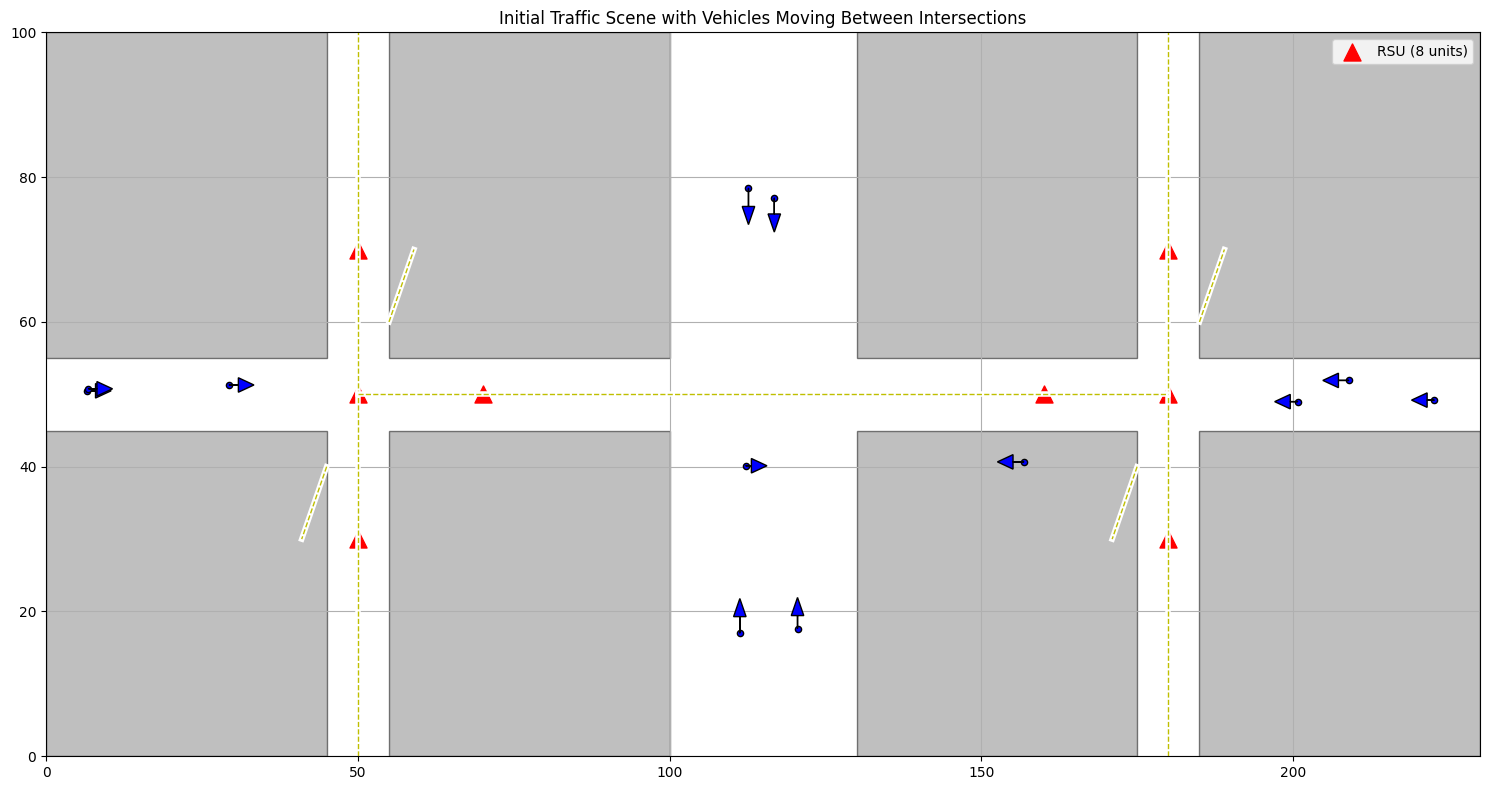

Epoch 0: Train Pos RMSE = 9.56 cm | Train Vel RMSE = 2.20 m/s | Val Pos RMSE = 2.80 cm | Val Vel RMSE = 5.53 m/s | Match Rate = 0.2%
Epoch 2: Train Pos RMSE = 10.05 cm | Train Vel RMSE = 2.12 m/s | Val Pos RMSE = 2.87 cm | Val Vel RMSE = 5.35 m/s | Match Rate = 0.4%
Epoch 4: Train Pos RMSE = 9.90 cm | Train Vel RMSE = 2.04 m/s | Val Pos RMSE = 2.90 cm | Val Vel RMSE = 4.92 m/s | Match Rate = 0.4%
Epoch 6: Train Pos RMSE = 10.24 cm | Train Vel RMSE = 1.86 m/s | Val Pos RMSE = 2.74 cm | Val Vel RMSE = 4.77 m/s | Match Rate = 0.3%
Epoch 8: Train Pos RMSE = 9.27 cm | Train Vel RMSE = 1.84 m/s | Val Pos RMSE = 2.91 cm | Val Vel RMSE = 4.47 m/s | Match Rate = 0.4%
Epoch 10: Train Pos RMSE = 9.88 cm | Train Vel RMSE = 1.72 m/s | Val Pos RMSE = 2.72 cm | Val Vel RMSE = 4.06 m/s | Match Rate = 0.3%
Epoch 12: Train Pos RMSE = 9.70 cm | Train Vel RMSE = 1.65 m/s | Val Pos RMSE = 2.49 cm | Val Vel RMSE = 3.95 m/s | Match Rate = 0.2%
Epoch 14: Train Pos RMSE = 10.37 cm | Train Vel RMSE = 1.50 m/s |

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
import numpy as np
from scipy.spatial import Delaunay, distance_matrix
from scipy.optimize import linear_sum_assignment
from scipy.signal import find_peaks
from shapely.geometry import LineString, Polygon, Point, MultiPoint
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from typing import List, Dict, Optional
from collections import defaultdict

# Physical Constants
RSU_BAND_FREQUENCY_HZ = 5.9e9  # 5.9 GHz
SPEED_OF_LIGHT = 3e8
MAX_RANGE = 200  # meters
MAX_VELOCITY = 33.3  # m/s
OTFS_GRID_SIZE = (128, 128)  # delay x Doppler
MIN_VEHICLE_SPACING = 3.0  # meters between vehicles
BUILDING_CLEARANCE = 10.0  # meters around buildings

class DualIntersection:
    def __init__(self, size=100, spacing=30):
        self.size = size
        self.spacing = spacing
        self.total_width = size * 2 + spacing
        self.buildings = self._create_buildings()
        self.roads = self._create_roads()
        self.rsu_positions = self._place_minimal_rsus()

    def _create_buildings(self):
        """Create buildings for both intersections"""
        b_size = 15
        offset = 5
        buildings = []

        # Left intersection buildings
        buildings.extend([
            Polygon([(0, self.size/2+offset), (0, self.size),
                   (self.size/2-offset, self.size), (self.size/2-offset, self.size/2+offset)]),  # NW
            Polygon([(self.size/2+offset, self.size), (self.size, self.size),
                   (self.size, self.size/2+offset), (self.size/2+offset, self.size/2+offset)]),  # NE
            Polygon([(self.size/2+offset, 0), (self.size, 0),
                   (self.size, self.size/2-offset), (self.size/2+offset, self.size/2-offset)]),  # SE
            Polygon([(0, 0), (self.size/2-offset, 0),
                   (self.size/2-offset, self.size/2-offset), (0, self.size/2-offset)])  # SW
        ])

        # Right intersection buildings
        x_shift = self.size + self.spacing
        buildings.extend([
            Polygon([(x_shift, self.size/2+offset), (x_shift, self.size),
                    (x_shift+self.size/2-offset, self.size), (x_shift+self.size/2-offset, self.size/2+offset)]),  # NW
            Polygon([(x_shift+self.size/2+offset, self.size), (x_shift+self.size, self.size),
                    (x_shift+self.size, self.size/2+offset), (x_shift+self.size/2+offset, self.size/2+offset)]),  # NE
            Polygon([(x_shift+self.size/2+offset, 0), (x_shift+self.size, 0),
                    (x_shift+self.size, self.size/2-offset), (x_shift+self.size/2+offset, self.size/2-offset)]),  # SE
            Polygon([(x_shift, 0), (x_shift+self.size/2-offset, 0),
                    (x_shift+self.size/2-offset, self.size/2-offset), (x_shift, self.size/2-offset)])  # SW
        ])
        return buildings

    def _create_roads(self):
        """Create roads connecting two intersections with proper lanes"""
        main_width = 10
        lane_width = 4
        x_shift = self.size + self.spacing

        roads = [
            # Vertical roads
            LineString([(self.size/2, 0), (self.size/2, self.size)]),  # Left vertical
            LineString([(x_shift+self.size/2, 0), (x_shift+self.size/2, self.size)]),  # Right vertical

            # Horizontal connecting road with two lanes
            LineString([(self.size/2, self.size/2), (x_shift+self.size/2, self.size/2)]),  # Center line

            # Left intersection lanes
            LineString([(self.size/2-main_width/2, self.size*0.4),
                       (self.size/2-main_width/2-lane_width, self.size*0.3)]),  # Left deceleration
            LineString([(self.size/2+main_width/2, self.size*0.6),
                       (self.size/2+main_width/2+lane_width, self.size*0.7)]),  # Left acceleration

            # Right intersection lanes
            LineString([(x_shift+self.size/2-main_width/2, self.size*0.4),
                       (x_shift+self.size/2-main_width/2-lane_width, self.size*0.3)]),  # Right deceleration
            LineString([(x_shift+self.size/2+main_width/2, self.size*0.6),
                       (x_shift+self.size/2+main_width/2+lane_width, self.size*0.7)]),  # Right acceleration
        ]
        return roads

    def _place_minimal_rsus(self):
        """Place RSUs at both intersections"""
        x_shift = self.size + self.spacing
        return np.array([
            # Left intersection
            [self.size/2, self.size/2],      # Center
            [self.size/2, self.size*0.7],    # North approach
            [self.size/2, self.size*0.3],    # South approach
            [self.size*0.7, self.size/2],    # East approach

            # Right intersection
            [x_shift+self.size/2, self.size/2],      # Center
            [x_shift+self.size/2, self.size*0.7],    # North approach
            [x_shift+self.size/2, self.size*0.3],    # South approach
            [x_shift+self.size*0.3, self.size/2]     # West approach
        ])

    def generate_traffic(self, num_vehicles=20):
        """Generate vehicles moving between both intersections"""
        vehicles = []
        x_shift = self.size + self.spacing
        mid_point = (self.size + x_shift) / 2

        for _ in range(num_vehicles):
            size = np.random.uniform(1.5, 2.5)
            direction = np.random.choice(['left_to_right', 'right_to_left', 'vertical', 'horizontal'])

            if direction == 'left_to_right':
                pos = np.array([np.random.uniform(0, self.size*0.3), self.size/2 + np.random.uniform(-2, 2)])
                vel = np.array([np.random.uniform(3, 5), 0]) * size
            elif direction == 'right_to_left':
                pos = np.array([np.random.uniform(x_shift+self.size*0.7, x_shift+self.size),
                               self.size/2 + np.random.uniform(-2, 2)])
                vel = np.array([-np.random.uniform(3, 5), 0]) * size
            elif direction == 'vertical':
                if np.random.rand() > 0.5:  # Northbound
                    pos = np.array([mid_point + np.random.uniform(-10, 10),
                                   np.random.uniform(0, self.size*0.3)])
                    vel = np.array([0, np.random.uniform(5, 7)]) * size
                else:  # Southbound
                    pos = np.array([mid_point + np.random.uniform(-10, 10),
                                   np.random.uniform(self.size*0.7, self.size)])
                    vel = np.array([0, -np.random.uniform(5, 7)]) * size
            else:  # horizontal crossing
                if np.random.rand() > 0.5:  # Eastbound
                    pos = np.array([np.random.uniform(self.size*0.7, x_shift+self.size*0.3),
                                   np.random.uniform(self.size*0.4, self.size*0.6)])
                    vel = np.array([np.random.uniform(3, 5), 0]) * size
                else:  # Westbound
                    pos = np.array([np.random.uniform(self.size*0.7, x_shift+self.size*0.3),
                                   np.random.uniform(self.size*0.4, self.size*0.6)])
                    vel = np.array([-np.random.uniform(3, 5), 0]) * size

            vehicles.append({
                'position': pos,
                'velocity': vel,
                'size': 15 * size,
                'color': np.random.choice(['blue', 'green', 'red', 'orange', 'purple']),
                'direction': direction
            })
        return vehicles

    def update_vehicles(self, vehicles):
        """Update vehicle positions with proper transitions between intersections"""
        updated_vehicles = []
        x_shift = self.size + self.spacing
        mid_point = (self.size + x_shift) / 2

        for vehicle in vehicles:
            pos = vehicle['position'] + vehicle['velocity'] * 0.1
            vel = vehicle['velocity'].copy()
            direction = vehicle['direction']

            # Handle transitions between intersections
            if direction in ['left_to_right', 'right_to_left']:
                if pos[0] < 0 or pos[0] > x_shift + self.size:
                    # Respawn on opposite side
                    if direction == 'left_to_right':
                        pos = np.array([0, self.size/2 + np.random.uniform(-2, 2)])
                        vel = np.array([np.random.uniform(3, 5), 0])
                    else:
                        pos = np.array([x_shift + self.size, self.size/2 + np.random.uniform(-2, 2)])
                        vel = np.array([-np.random.uniform(3, 5), 0])
            else:  # Vertical or crossing movement
                if pos[1] < 0 or pos[1] > self.size:
                    # Respawn at top or bottom
                    if np.random.rand() > 0.5:  # Northbound
                        pos = np.array([mid_point + np.random.uniform(-10, 10), 0])
                        vel = np.array([0, np.random.uniform(5, 7)])
                    else:  # Southbound
                        pos = np.array([mid_point + np.random.uniform(-10, 10), self.size])
                        vel = np.array([0, -np.random.uniform(5, 7)])

            updated_vehicles.append({
                'position': pos,
                'velocity': vel,
                'size': vehicle['size'],
                'color': vehicle['color'],
                'direction': direction
            })
        return updated_vehicles

    def visualize(self, vehicles=None, title="Dual Intersection with Vehicles"):
        """Visualize the dual intersection with vehicles and their directions"""
        plt.figure(figsize=(15, 8))

        # Buildings
        for building in self.buildings:
            x, y = building.exterior.xy
            plt.fill(x, y, 'gray', alpha=0.5, edgecolor='black')

        # Roads
        for road in self.roads:
            x, y = road.xy
            plt.plot(x, y, 'w-', linewidth=4)
            plt.plot(x, y, 'y--', linewidth=1)

        # RSUs
        plt.scatter(self.rsu_positions[:, 0], self.rsu_positions[:, 1],
                  c='red', marker='^', s=150, label='RSU (8 units)')

        # Vehicles
        if vehicles:
            for vehicle in vehicles:
                # Vehicle body
                plt.scatter(vehicle['position'][0], vehicle['position'][1],
                           c=vehicle['color'], s=vehicle['size'],
                           edgecolor='black', linewidth=1, zorder=10)

                # Direction arrow
                plt.arrow(vehicle['position'][0], vehicle['position'][1],
                         vehicle['velocity'][0]/5, vehicle['velocity'][1]/5,
                         head_width=2, head_length=2.5,
                         fc=vehicle['color'], ec='black', zorder=10)

        plt.xlim(0, self.total_width)
        plt.ylim(0, self.size)
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def animate(self, frames=100, interval=100):
        """Animate vehicle movement between intersections"""
        fig, ax = plt.subplots(figsize=(15, 8))
        vehicles = self.generate_traffic(20)

        def init():
            ax.clear()
            # Buildings
            for building in self.buildings:
                x, y = building.exterior.xy
                ax.fill(x, y, 'gray', alpha=0.5, edgecolor='black')
            # Roads
            for road in self.roads:
                x, y = road.xy
                ax.plot(x, y, 'w-', linewidth=4)
                ax.plot(x, y, 'y--', linewidth=1)
            # RSUs
            ax.scatter(self.rsu_positions[:, 0], self.rsu_positions[:, 1],
                      c='red', marker='^', s=150, label='RSU')
            ax.set_xlim(0, self.total_width)
            ax.set_ylim(0, self.size)
            ax.set_title("Dual Intersection Traffic Simulation")
            ax.legend()
            ax.grid(True)
            return []

        def update(frame):
            nonlocal vehicles
            ax.clear()

            # Static elements
            for building in self.buildings:
                x, y = building.exterior.xy
                ax.fill(x, y, 'gray', alpha=0.5, edgecolor='black')
            for road in self.roads:
                x, y = road.xy
                ax.plot(x, y, 'w-', linewidth=4)
                ax.plot(x, y, 'y--', linewidth=1)
            ax.scatter(self.rsu_positions[:, 0], self.rsu_positions[:, 1],
                      c='red', marker='^', s=150, label='RSU')

            # Update and draw vehicles
            vehicles = self.update_vehicles(vehicles)
            for vehicle in vehicles:
                ax.scatter(vehicle['position'][0], vehicle['position'][1],
                         c=vehicle['color'], s=vehicle['size'],
                         edgecolor='black', linewidth=1, zorder=10)
                ax.arrow(vehicle['position'][0], vehicle['position'][1],
                        vehicle['velocity'][0]/5, vehicle['velocity'][1]/5,
                        head_width=2, head_length=2.5,
                        fc=vehicle['color'], ec='black', zorder=10)

            ax.set_xlim(0, self.total_width)
            ax.set_ylim(0, self.size)
            ax.set_title(f"Dual Intersection Traffic - Frame {frame+1}/{frames}")
            ax.legend()
            ax.grid(True)
            return []

        ani = FuncAnimation(fig, update, frames=frames, init_func=init,
                          interval=interval, blit=False)
        plt.close()
        return ani

class OTFSChannelModel:
    def __init__(self, env: DualIntersection):
        self.env = env
        self.delay_resolution = MAX_RANGE / OTFS_GRID_SIZE[0]
        self.doppler_resolution = 2*MAX_VELOCITY / OTFS_GRID_SIZE[1]

    def _free_space_path_loss(self, distance):
        lambda_ = SPEED_OF_LIGHT / RSU_BAND_FREQUENCY_HZ
        return (lambda_ / (4 * np.pi * distance))**2

    def _calculate_doppler(self, target_pos, target_vel, rx_pos):
        unit_vec = (target_pos - rx_pos) / (np.linalg.norm(target_pos - rx_pos) + 1e-6)
        return 2 * np.dot(target_vel, unit_vec) * RSU_BAND_FREQUENCY_HZ / SPEED_OF_LIGHT

    def _find_reflection(self, tx_pos, rx_pos, building):
        """Find reflection points on buildings"""
        tx_point, rx_point = Point(tx_pos), Point(rx_pos)
        tx_rx_line = LineString([tx_point, rx_point])

        if not building.exterior.intersects(tx_rx_line):
            return None

        intersection = building.exterior.intersection(tx_rx_line)
        if intersection.is_empty:
            return None

        if isinstance(intersection, MultiPoint):
            return np.array([intersection[0].x, intersection[0].y])

        return np.array([intersection.x, intersection.y])

    def generate_channel_response(self, tx_pos, rx_pos, target_pos, target_vel):
        channel_grid = np.zeros(OTFS_GRID_SIZE)

        # Direct path
        if not self._is_blocked(tx_pos, target_pos) and not self._is_blocked(target_pos, rx_pos):
            distance = np.linalg.norm(tx_pos - target_pos) + np.linalg.norm(target_pos - rx_pos)
            self._add_path_to_grid(channel_grid, distance, target_pos, target_vel, rx_pos, is_direct=True)

        # Reflected paths (up to 2 bounces)
        for building in self.env.buildings:
            reflection_point = self._find_reflection(tx_pos, rx_pos, building)
            if reflection_point is not None:
                if not self._is_blocked(reflection_point, rx_pos):
                    distance = (np.linalg.norm(tx_pos - reflection_point) +
                              np.linalg.norm(reflection_point - target_pos) +
                              np.linalg.norm(target_pos - rx_pos))
                    self._add_path_to_grid(channel_grid, distance, target_pos, target_vel,
                                         reflection_point, is_direct=False)

        return channel_grid

    def _is_blocked(self, p1, p2):
        """Check if line between points intersects any building"""
        line = LineString([p1, p2])
        return any(building.intersects(line) for building in self.env.buildings)

    def _add_path_to_grid(self, grid, distance, target_pos, target_vel, interaction_point, is_direct):
        """Add propagation path to the OTFS grid"""
        delay = distance / SPEED_OF_LIGHT
        doppler = self._calculate_doppler(target_pos, target_vel, interaction_point)
        power = self._free_space_path_loss(distance)

        if not is_direct:
            power *= 0.4  # Reflection coefficient

        delay_bin = min(int(delay / self.delay_resolution), OTFS_GRID_SIZE[0]-1)
        doppler_bin = min(int((doppler + MAX_VELOCITY) / (2*MAX_VELOCITY) * OTFS_GRID_SIZE[1]),
                        OTFS_GRID_SIZE[1]-1)

        if delay_bin >= 0 and doppler_bin >= 0:
            grid[delay_bin, doppler_bin] += power

class OTFSMeasurementGenerator:
    def __init__(self, env: DualIntersection, snr_db=25, augment=True):
        self.env = env
        self.snr = 10**(snr_db/10)
        self.channel_model = OTFSChannelModel(env)
        self.augment = augment

    def generate_measurements(self, rsu_pos, target_pos, target_vel):
        measurements = []
        for rsu_idx, rsu_p in enumerate(rsu_pos):
            channel_response = np.zeros(OTFS_GRID_SIZE)
            for t_idx, (t_pos, t_vel) in enumerate(zip(target_pos, target_vel)):
                channel_response += self.channel_model.generate_channel_response(
                    rsu_p, rsu_p, t_pos, t_vel)

            noisy_response = channel_response + np.random.normal(0, 1/np.sqrt(self.snr), OTFS_GRID_SIZE)
            peaks, _ = find_peaks(noisy_response.flatten(), height=0.1)

            for peak in peaks:
                delay_bin, doppler_bin = np.unravel_index(peak, OTFS_GRID_SIZE)
                measurements.append({
                    'rsu_idx': rsu_idx,
                    'rsu_pos': rsu_p,
                    'delay': delay_bin * self.channel_model.delay_resolution,
                    'doppler': doppler_bin * self.channel_model.doppler_resolution - MAX_VELOCITY,
                    'theta': np.random.uniform(-np.pi, np.pi),
                    'power': noisy_response[delay_bin, doppler_bin]
                })

        if self.augment and np.random.rand() > 0.5:
            for m in measurements:
                m['power'] *= np.random.uniform(0.8, 1.2)
                m['theta'] += np.random.normal(0, 0.1)
        return measurements

class EnhancedGNN(nn.Module):
    def __init__(self, in_channels=9, hidden_channels=128, dropout=0.2):
        super().__init__()
        self.dropout_rate = dropout
        self.hidden_channels = hidden_channels

        # Positional encoding
        self.pos_encoder = nn.Linear(2, hidden_channels)

        # Input projection to match expected dimensions
        self.input_proj = nn.Linear(in_channels, hidden_channels)

        # Graph attention layers
        self.conv1 = pyg_nn.GATv2Conv(hidden_channels, hidden_channels, edge_dim=5)
        self.bn1 = nn.BatchNorm1d(hidden_channels)

        self.conv2 = pyg_nn.GATv2Conv(hidden_channels, hidden_channels, edge_dim=5)
        self.bn2 = nn.BatchNorm1d(hidden_channels)

        self.conv3 = pyg_nn.GATv2Conv(hidden_channels, hidden_channels, edge_dim=5)

        # Prediction heads
        self.pos_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels//2),
            nn.ReLU(),
            nn.Linear(hidden_channels//2, 2)
        )

        self.vel_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels//2),
            nn.ReLU(),
            nn.Linear(hidden_channels//2, 2)
        )

        # Edge classifier
        self.edge_classifier = nn.Sequential(
            nn.Linear(2*hidden_channels + 5, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # Apply input projection
        x = self.input_proj(x)

        # Graph processing
        x = F.relu(self.bn1(self.conv1(x, edge_index, edge_attr)))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = F.relu(self.bn2(self.conv2(x, edge_index, edge_attr)))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = F.relu(self.conv3(x, edge_index, edge_attr))

        # Predictions
        pos_offsets = self.pos_head(x[:data.num_target_nodes])
        vel = self.vel_head(x[:data.num_target_nodes])

        # Edge classification
        edge_feat = torch.cat([x[edge_index[0]], x[edge_index[1]], edge_attr], dim=1)
        edge_scores = self.edge_classifier(edge_feat).squeeze()

        return edge_scores, pos_offsets, vel

class ISACTrainer:
    def __init__(self, num_scenes=1000, train_ratio=0.8):
        self.env = DualIntersection(size=100, spacing=30)

        # Generate all scenes with fixed seed for reproducibility
        np.random.seed(42)
        self.train_scenes = [self._generate_scene() for _ in range(int(num_scenes*train_ratio))]
        self.val_scenes = [self._generate_scene() for _ in range(int(num_scenes*(1-train_ratio)//2))]
        self.test_scenes = [self._generate_scene() for _ in range(int(num_scenes*(1-train_ratio)//2))]
        np.random.seed(None)

        # Measurement generators
        self.train_meas_generator = OTFSMeasurementGenerator(self.env, augment=True)
        self.val_meas_generator = OTFSMeasurementGenerator(self.env, augment=False)
        self.test_meas_generator = OTFSMeasurementGenerator(self.env, augment=False)

        # Model and optimizer
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = EnhancedGNN().to(self.device)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=1e-4)
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer, max_lr=1e-3, steps_per_epoch=100, epochs=100)

        self.best_val_loss = float('inf')
        self.early_stop_counter = 0
        self.patience = 10

    def _generate_scene(self):
        """Generate a scene with vehicles moving between intersections"""
        vehicles = self.env.generate_traffic(np.random.randint(8, 20))
        target_pos = np.array([v['position'] for v in vehicles])
        target_vel = np.array([v['velocity'] for v in vehicles])
        return target_pos, target_vel, self.env.rsu_positions

    def build_graph(self, measurements, gt_pos=None):
        if not measurements:
            return None

        meas_features = []
        for m in measurements:
            x = m['rsu_pos'][0] + m['delay'] * SPEED_OF_LIGHT/2 * np.cos(m['theta'])
            y = m['rsu_pos'][1] + m['delay'] * SPEED_OF_LIGHT/2 * np.sin(m['theta'])

            meas_features.append([
                x/MAX_RANGE, y/MAX_RANGE,
                m['delay']/(2*MAX_RANGE/SPEED_OF_LIGHT),
                (m['doppler'] + MAX_VELOCITY)/(2*MAX_VELOCITY),
                np.log10(m['power'] + 1e-6),
                np.cos(m['theta']), np.sin(m['theta']),
                m['rsu_pos'][0]/MAX_RANGE, m['rsu_pos'][1]/MAX_RANGE
            ])

        # Cluster measurements
        coords = np.array([f[:2] for f in meas_features])
        clustering = DBSCAN(eps=0.1, min_samples=2).fit(coords)
        labels = clustering.labels_

        candidates = []
        for lbl in set(labels):
            if lbl != -1 and np.sum(labels == lbl) > 1:
                cluster_mask = (labels == lbl)
                cluster_feats = np.array(meas_features)[cluster_mask]
                weights = 10**cluster_feats[:,4]

                centroid = np.average(cluster_feats[:,:2], axis=0, weights=weights)
                avg_delay = np.average(cluster_feats[:,2], weights=weights)
                avg_doppler = np.average(cluster_feats[:,3], weights=weights)
                avg_power = np.mean(cluster_feats[:,4])
                avg_angle = np.arctan2(
                    np.average(cluster_feats[:,6], weights=weights),
                    np.average(cluster_feats[:,5], weights=weights))

                candidates.append([
                    *centroid, avg_delay, avg_doppler, avg_power,
                    np.cos(avg_angle), np.sin(avg_angle),
                    *cluster_feats[0,7:9]
                ])

        if not candidates:
            candidates = meas_features

        x = torch.tensor(candidates + meas_features, dtype=torch.float)
        num_cands = len(candidates)

        # Create edges
        edge_index, edge_attr = [], []
        for i in range(num_cands):
            for j in range(num_cands, len(x)):
                angle_diff = torch.abs(torch.atan2(x[i,6], x[i,5]) - torch.atan2(x[j,6], x[j,5]))
                dist = torch.norm(x[j,:2] - x[i,:2])

                if angle_diff < np.pi/2 or dist < 0.25:
                    doppler_diff = torch.abs(x[j,3] - x[i,3])
                    power_ratio = x[j,4] - x[i,4]

                    edge_feat = torch.cat([
                        x[j,:2] - x[i,:2],
                        torch.tensor([dist, doppler_diff, power_ratio])
                    ])

                    edge_index.append([i,j])
                    edge_attr.append(edge_feat)

        if not edge_index:
            return None

        return Data(
            x=x,
            edge_index=torch.tensor(edge_index).t().contiguous(),
            edge_attr=torch.stack(edge_attr),
            num_target_nodes=num_cands
        )

    def train_epoch(self):
        self.model.train()
        total_pos_loss = 0
        total_vel_loss = 0
        total_matches = 0
        batch_count = 0

        for _ in range(16):  # Process 16 scenes per batch
            gt_pos, gt_vel, rsu_pos = self._generate_scene()
            measurements = self.train_meas_generator.generate_measurements(rsu_pos, gt_pos, gt_vel)

            # Normalize ground truth
            gt_pos_norm = gt_pos / MAX_RANGE
            gt_vel_norm = gt_vel / (2*MAX_VELOCITY)

            graph = self.build_graph(measurements, gt_pos_norm)
            if graph is None:
                continue

            graph = graph.to(self.device)
            self.optimizer.zero_grad()

            edge_scores, pos_offsets, vel = self.model(graph)
            pred_pos = graph.x[:graph.num_target_nodes, :2] + pos_offsets
            pred_vel = vel * (2*MAX_VELOCITY)

            # Hungarian matching
            cost = torch.cdist(pred_pos, torch.tensor(gt_pos_norm, device=self.device).float())
            row_ind, col_ind = linear_sum_assignment(cost.cpu().detach().numpy())

            if len(row_ind) > 0:
                pos_loss = F.mse_loss(pred_pos[row_ind],
                                    torch.tensor(gt_pos_norm[col_ind], device=self.device).float())
                vel_loss = F.mse_loss(pred_vel[row_ind],
                                    torch.tensor(gt_vel_norm[col_ind], device=self.device).float())
                loss = pos_loss + 0.1*vel_loss

                loss.backward()
                total_pos_loss += pos_loss.item()
                total_vel_loss += vel_loss.item()
                total_matches += len(row_ind)
                batch_count += 1

        if batch_count > 0:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.scheduler.step()

            avg_pos_rmse = torch.sqrt(torch.tensor(total_pos_loss/max(1,total_matches))).item()
            avg_vel_rmse = torch.sqrt(torch.mean(torch.tensor(total_vel_loss/max(1,total_matches)))).item()
            return avg_pos_rmse, avg_vel_rmse, total_matches
        return None

    def validate(self, test_mode=False):
        self.model.eval()
        val_metrics = {'pos': [], 'vel': []}
        total_targets = 0
        matched_targets = 0

        scenes = self.test_scenes if test_mode else self.val_scenes
        for gt_pos, gt_vel, rsu_pos in scenes:
            gt_pos_norm = gt_pos / MAX_RANGE
            gt_vel_norm = gt_vel / (2*MAX_VELOCITY)

            measurements = self.test_meas_generator.generate_measurements(rsu_pos, gt_pos, gt_vel) if test_mode \
                          else self.val_meas_generator.generate_measurements(rsu_pos, gt_pos, gt_vel)
            graph = self.build_graph(measurements, gt_pos_norm)

            if graph is None:
                total_targets += len(gt_pos)
                continue

            graph = graph.to(self.device)
            _, pos_offsets, vel = self.model(graph)
            pred_pos = graph.x[:graph.num_target_nodes, :2] + pos_offsets
            pred_vel = vel * (2*MAX_VELOCITY)

            # Threshold-based matching
            dist_matrix = torch.cdist(pred_pos, torch.tensor(gt_pos_norm, device=self.device).float())
            matches = dist_matrix < 0.15  # 5m threshold

            for i in range(len(gt_pos)):
                if torch.any(matches[:,i]):
                    match_idx = torch.argmin(dist_matrix[:,i])
                    val_metrics['pos'].append(F.mse_loss(pred_pos[match_idx],
                                             torch.tensor(gt_pos_norm[i], device=self.device).float()).item())
                    val_metrics['vel'].append(F.mse_loss(pred_vel[match_idx],
                                             torch.tensor(gt_vel_norm[i], device=self.device).float()).item())
                    matched_targets += 1
            total_targets += len(gt_pos)

        pos_rmse = torch.sqrt(torch.mean(torch.tensor(val_metrics['pos']))).item() if val_metrics['pos'] else float('nan')
        vel_rmse = torch.sqrt(torch.mean(torch.tensor(val_metrics['vel']))).item() if val_metrics['vel'] else float('nan')
        match_rate = matched_targets / total_targets if total_targets > 0 else 0

        return {
            'pos_rmse': pos_rmse,
            'vel_rmse': vel_rmse,
            'match_rate': match_rate
        }

    def train(self, epochs=100):
        print("Starting training with dual intersection environment...")

        # Visualize initial scene with vehicles moving between intersections
        gt_pos, gt_vel, rsu_pos = self._generate_scene()
        vehicles = [{'position': pos, 'velocity': vel,
                     'size': 20, 'color': 'blue'} for pos, vel in zip(gt_pos, gt_vel)]
        self.env.visualize(vehicles, title="Initial Traffic Scene with Vehicles Moving Between Intersections")

        for epoch in range(epochs):
            train_result = self.train_epoch()

            if train_result is None:
                print(f"Epoch {epoch}: No valid training batches")
                continue

            train_pos_rmse, train_vel_rmse, num_matched = train_result

            # Validation every 2 epochs
            if epoch % 2 == 0:
                val_results = self.validate()
                val_loss = val_results['pos_rmse'] + 0.1 * val_results['vel_rmse']

                # Early stopping check
                if val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                    torch.save(self.model.state_dict(), 'best_model.pth')
                    self.early_stop_counter = 0
                else:
                    self.early_stop_counter += 1
                    if self.early_stop_counter >= self.patience:
                        print(f"Early stopping at epoch {epoch}")
                        break

                print(f"Epoch {epoch}: "
                      f"Train Pos RMSE = {train_pos_rmse*100:.2f} cm | "
                      f"Train Vel RMSE = {train_vel_rmse:.2f} m/s | "
                      f"Val Pos RMSE = {val_results['pos_rmse']*100:.2f} cm | "
                      f"Val Vel RMSE = {val_results['vel_rmse']:.2f} m/s | "
                      f"Match Rate = {val_results['match_rate']:.1%}")

        # Final evaluation
        print("\n=== Final Evaluation ===")
        self.model.load_state_dict(torch.load('best_model.pth'))

        final_val = self.validate()
        print(f"Validation - Pos: {final_val['pos_rmse']*100:.2f} cm | "
              f"Vel: {final_val['vel_rmse']:.2f} m/s | "
              f"Match Rate: {final_val['match_rate']:.1%}")

        final_test = self.validate(test_mode=True)
        print(f"Test - Pos: {final_test['pos_rmse']*100:.2f} cm | "
              f"Vel: {final_test['vel_rmse']:.2f} m/s | "
              f"Match Rate: {final_test['match_rate']:.1%}")

if __name__ == '__main__':
    trainer = ISACTrainer(num_scenes=1000, train_ratio=0.8)
    trainer.train(epochs=100)

    # Show animation of vehicles moving between intersections
    sim = DualIntersection(size=100, spacing=30)
    ani = sim.animate(frames=100, interval=100)
    plt.show()

Starting training with dual intersection environment...


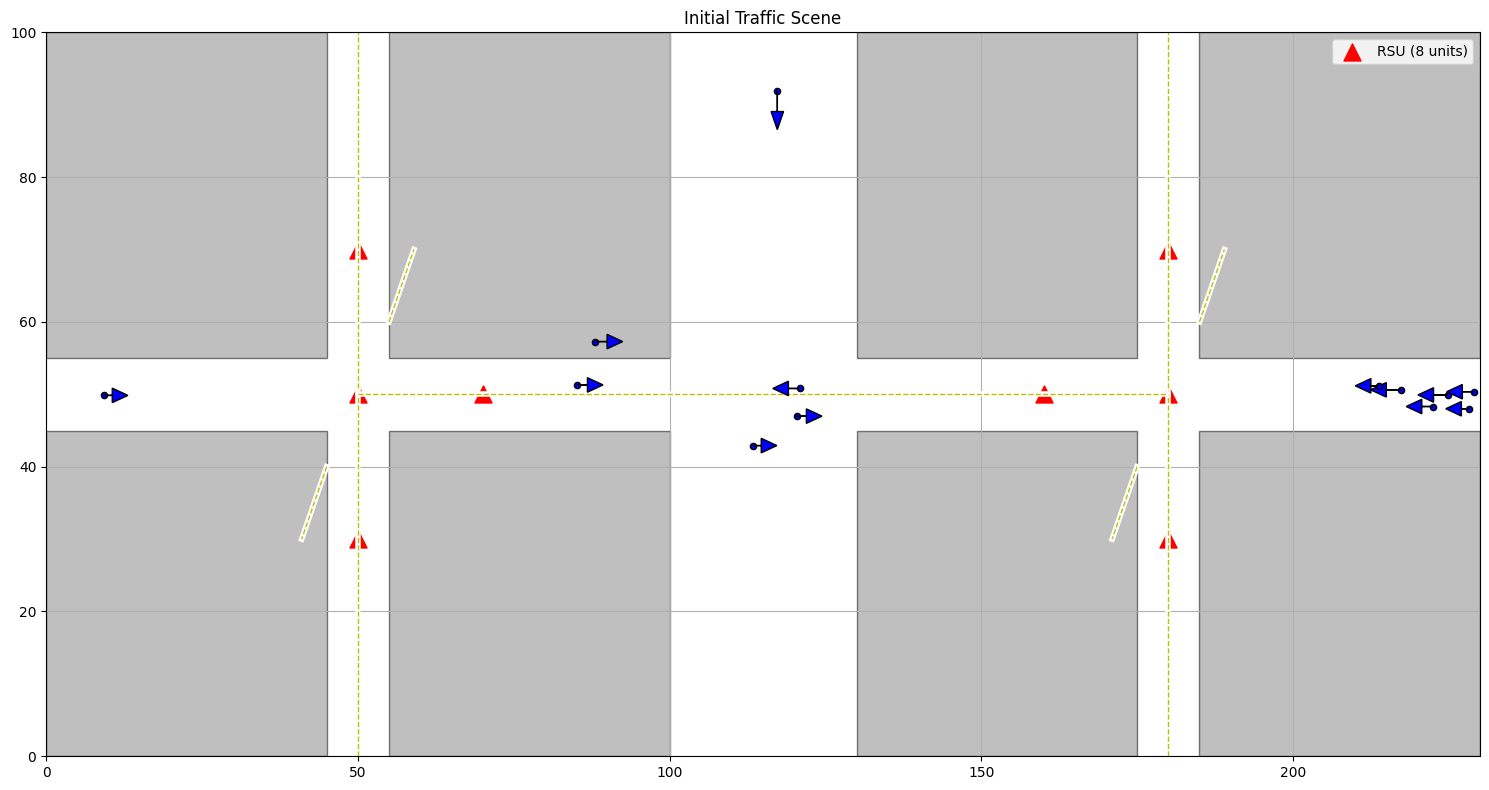

New best model saved at epoch 0
Epoch 000: Train Pos = 5.52cm | Train Vel = 3.44m/s | Val Pos = 7.36cm | Val Vel = 4.25m/s | Matches = 32
New best model saved at epoch 1
Epoch 001: Train Pos = 4.87cm | Train Vel = 3.45m/s | Val Pos = 6.95cm | Val Vel = 4.11m/s | Matches = 32
New best model saved at epoch 2
Epoch 002: Train Pos = 4.91cm | Train Vel = 3.31m/s | Val Pos = 6.96cm | Val Vel = 3.83m/s | Matches = 32
Epoch 003: Train Pos = 5.27cm | Train Vel = 3.23m/s | Val Pos = 6.92cm | Val Vel = 4.02m/s | Matches = 34
Epoch 004: Train Pos = 5.19cm | Train Vel = 3.35m/s | Val Pos = 6.75cm | Val Vel = 4.10m/s | Matches = 32
Epoch 005: Train Pos = 4.86cm | Train Vel = 3.15m/s | Val Pos = 6.88cm | Val Vel = 4.47m/s | Matches = 32
New best model saved at epoch 6
Epoch 006: Train Pos = 5.45cm | Train Vel = 3.09m/s | Val Pos = 6.88cm | Val Vel = 3.33m/s | Matches = 32
Epoch 007: Train Pos = 5.12cm | Train Vel = 2.97m/s | Val Pos = 6.77cm | Val Vel = 4.45m/s | Matches = 32
Epoch 008: Train Pos = 4

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
import numpy as np
from scipy.spatial import Delaunay, distance_matrix
from scipy.optimize import linear_sum_assignment
from scipy.signal import find_peaks
from shapely.geometry import LineString, Polygon, Point, MultiPoint
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from typing import List, Dict, Optional
from collections import defaultdict

# Physical Constants
RSU_BAND_FREQUENCY_HZ = 5.9e9  # 5.9 GHz
SPEED_OF_LIGHT = 3e8
MAX_RANGE = 200  # meters
MAX_VELOCITY = 33.3  # m/s
OTFS_GRID_SIZE = (128, 128)  # delay x Doppler
MIN_VEHICLE_SPACING = 3.0  # meters between vehicles
BUILDING_CLEARANCE = 10.0  # meters around buildings

class DualIntersection:
    def __init__(self, size=100, spacing=30):
        self.size = size
        self.spacing = spacing
        self.total_width = size * 2 + spacing
        self.buildings = self._create_buildings()
        self.roads = self._create_roads()
        self.rsu_positions = self._place_minimal_rsus()

    def _create_buildings(self):
        """Create buildings for both intersections"""
        b_size = 15
        offset = 5
        buildings = []

        # Left intersection buildings
        buildings.extend([
            Polygon([(0, self.size/2+offset), (0, self.size),
                   (self.size/2-offset, self.size), (self.size/2-offset, self.size/2+offset)]),  # NW
            Polygon([(self.size/2+offset, self.size), (self.size, self.size),
                   (self.size, self.size/2+offset), (self.size/2+offset, self.size/2+offset)]),  # NE
            Polygon([(self.size/2+offset, 0), (self.size, 0),
                   (self.size, self.size/2-offset), (self.size/2+offset, self.size/2-offset)]),  # SE
            Polygon([(0, 0), (self.size/2-offset, 0),
                   (self.size/2-offset, self.size/2-offset), (0, self.size/2-offset)])  # SW
        ])

        # Right intersection buildings
        x_shift = self.size + self.spacing
        buildings.extend([
            Polygon([(x_shift, self.size/2+offset), (x_shift, self.size),
                    (x_shift+self.size/2-offset, self.size), (x_shift+self.size/2-offset, self.size/2+offset)]),  # NW
            Polygon([(x_shift+self.size/2+offset, self.size), (x_shift+self.size, self.size),
                    (x_shift+self.size, self.size/2+offset), (x_shift+self.size/2+offset, self.size/2+offset)]),  # NE
            Polygon([(x_shift+self.size/2+offset, 0), (x_shift+self.size, 0),
                    (x_shift+self.size, self.size/2-offset), (x_shift+self.size/2+offset, self.size/2-offset)]),  # SE
            Polygon([(x_shift, 0), (x_shift+self.size/2-offset, 0),
                    (x_shift+self.size/2-offset, self.size/2-offset), (x_shift, self.size/2-offset)])  # SW
        ])
        return buildings

    def _create_roads(self):
        """Create roads connecting two intersections with proper lanes"""
        main_width = 10
        lane_width = 4
        x_shift = self.size + self.spacing

        roads = [
            # Vertical roads
            LineString([(self.size/2, 0), (self.size/2, self.size)]),  # Left vertical
            LineString([(x_shift+self.size/2, 0), (x_shift+self.size/2, self.size)]),  # Right vertical

            # Horizontal connecting road with two lanes
            LineString([(self.size/2, self.size/2), (x_shift+self.size/2, self.size/2)]),  # Center line

            # Left intersection lanes
            LineString([(self.size/2-main_width/2, self.size*0.4),
                       (self.size/2-main_width/2-lane_width, self.size*0.3)]),  # Left deceleration
            LineString([(self.size/2+main_width/2, self.size*0.6),
                       (self.size/2+main_width/2+lane_width, self.size*0.7)]),  # Left acceleration

            # Right intersection lanes
            LineString([(x_shift+self.size/2-main_width/2, self.size*0.4),
                       (x_shift+self.size/2-main_width/2-lane_width, self.size*0.3)]),  # Right deceleration
            LineString([(x_shift+self.size/2+main_width/2, self.size*0.6),
                       (x_shift+self.size/2+main_width/2+lane_width, self.size*0.7)]),  # Right acceleration
        ]
        return roads

    def _place_minimal_rsus(self):
        """Place RSUs at both intersections"""
        x_shift = self.size + self.spacing
        return np.array([
            # Left intersection
            [self.size/2, self.size/2],      # Center
            [self.size/2, self.size*0.7],    # North approach
            [self.size/2, self.size*0.3],    # South approach
            [self.size*0.7, self.size/2],    # East approach

            # Right intersection
            [x_shift+self.size/2, self.size/2],      # Center
            [x_shift+self.size/2, self.size*0.7],    # North approach
            [x_shift+self.size/2, self.size*0.3],    # South approach
            [x_shift+self.size*0.3, self.size/2]     # West approach
        ])

    def generate_traffic(self, num_vehicles=20):
        """Generate vehicles moving between both intersections"""
        vehicles = []
        x_shift = self.size + self.spacing
        mid_point = (self.size + x_shift) / 2

        for _ in range(num_vehicles):
            size = np.random.uniform(1.5, 2.5)
            direction = np.random.choice(['left_to_right', 'right_to_left', 'vertical', 'horizontal'])

            if direction == 'left_to_right':
                pos = np.array([np.random.uniform(0, self.size*0.3), self.size/2 + np.random.uniform(-2, 2)])
                vel = np.array([np.random.uniform(3, 5), 0]) * size
            elif direction == 'right_to_left':
                pos = np.array([np.random.uniform(x_shift+self.size*0.7, x_shift+self.size),
                               self.size/2 + np.random.uniform(-2, 2)])
                vel = np.array([-np.random.uniform(3, 5), 0]) * size
            elif direction == 'vertical':
                if np.random.rand() > 0.5:  # Northbound
                    pos = np.array([mid_point + np.random.uniform(-10, 10),
                                   np.random.uniform(0, self.size*0.3)])
                    vel = np.array([0, np.random.uniform(5, 7)]) * size
                else:  # Southbound
                    pos = np.array([mid_point + np.random.uniform(-10, 10),
                                   np.random.uniform(self.size*0.7, self.size)])
                    vel = np.array([0, -np.random.uniform(5, 7)]) * size
            else:  # horizontal crossing
                if np.random.rand() > 0.5:  # Eastbound
                    pos = np.array([np.random.uniform(self.size*0.7, x_shift+self.size*0.3),
                                   np.random.uniform(self.size*0.4, self.size*0.6)])
                    vel = np.array([np.random.uniform(3, 5), 0]) * size
                else:  # Westbound
                    pos = np.array([np.random.uniform(self.size*0.7, x_shift+self.size*0.3),
                                   np.random.uniform(self.size*0.4, self.size*0.6)])
                    vel = np.array([-np.random.uniform(3, 5), 0]) * size

            vehicles.append({
                'position': pos,
                'velocity': vel,
                'size': 15 * size,
                'color': np.random.choice(['blue', 'green', 'red', 'orange', 'purple']),
                'direction': direction
            })
        return vehicles

    def update_vehicles(self, vehicles):
        """Update vehicle positions with proper transitions between intersections"""
        updated_vehicles = []
        x_shift = self.size + self.spacing
        mid_point = (self.size + x_shift) / 2

        for vehicle in vehicles:
            pos = vehicle['position'] + vehicle['velocity'] * 0.1
            vel = vehicle['velocity'].copy()
            direction = vehicle['direction']

            # Handle transitions between intersections
            if direction in ['left_to_right', 'right_to_left']:
                if pos[0] < 0 or pos[0] > x_shift + self.size:
                    # Respawn on opposite side
                    if direction == 'left_to_right':
                        pos = np.array([0, self.size/2 + np.random.uniform(-2, 2)])
                        vel = np.array([np.random.uniform(3, 5), 0])
                    else:
                        pos = np.array([x_shift + self.size, self.size/2 + np.random.uniform(-2, 2)])
                        vel = np.array([-np.random.uniform(3, 5), 0])
            else:  # Vertical or crossing movement
                if pos[1] < 0 or pos[1] > self.size:
                    # Respawn at top or bottom
                    if np.random.rand() > 0.5:  # Northbound
                        pos = np.array([mid_point + np.random.uniform(-10, 10), 0])
                        vel = np.array([0, np.random.uniform(5, 7)])
                    else:  # Southbound
                        pos = np.array([mid_point + np.random.uniform(-10, 10), self.size])
                        vel = np.array([0, -np.random.uniform(5, 7)])

            updated_vehicles.append({
                'position': pos,
                'velocity': vel,
                'size': vehicle['size'],
                'color': vehicle['color'],
                'direction': direction
            })
        return updated_vehicles

    def visualize(self, vehicles=None, title="Dual Intersection with Vehicles"):
        """Visualize the dual intersection with vehicles and their directions"""
        plt.figure(figsize=(15, 8))

        # Buildings
        for building in self.buildings:
            x, y = building.exterior.xy
            plt.fill(x, y, 'gray', alpha=0.5, edgecolor='black')

        # Roads
        for road in self.roads:
            x, y = road.xy
            plt.plot(x, y, 'w-', linewidth=4)
            plt.plot(x, y, 'y--', linewidth=1)

        # RSUs
        plt.scatter(self.rsu_positions[:, 0], self.rsu_positions[:, 1],
                  c='red', marker='^', s=150, label='RSU (8 units)')

        # Vehicles
        if vehicles:
            for vehicle in vehicles:
                # Vehicle body
                plt.scatter(vehicle['position'][0], vehicle['position'][1],
                           c=vehicle['color'], s=vehicle['size'],
                           edgecolor='black', linewidth=1, zorder=10)

                # Direction arrow
                plt.arrow(vehicle['position'][0], vehicle['position'][1],
                         vehicle['velocity'][0]/5, vehicle['velocity'][1]/5,
                         head_width=2, head_length=2.5,
                         fc=vehicle['color'], ec='black', zorder=10)

        plt.xlim(0, self.total_width)
        plt.ylim(0, self.size)
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def animate(self, frames=100, interval=100):
        """Animate vehicle movement between intersections"""
        fig, ax = plt.subplots(figsize=(15, 8))
        vehicles = self.generate_traffic(20)

        def init():
            ax.clear()
            # Buildings
            for building in self.buildings:
                x, y = building.exterior.xy
                ax.fill(x, y, 'gray', alpha=0.5, edgecolor='black')
            # Roads
            for road in self.roads:
                x, y = road.xy
                ax.plot(x, y, 'w-', linewidth=4)
                ax.plot(x, y, 'y--', linewidth=1)
            # RSUs
            ax.scatter(self.rsu_positions[:, 0], self.rsu_positions[:, 1],
                      c='red', marker='^', s=150, label='RSU')
            ax.set_xlim(0, self.total_width)
            ax.set_ylim(0, self.size)
            ax.set_title("Dual Intersection Traffic Simulation")
            ax.legend()
            ax.grid(True)
            return []

        def update(frame):
            nonlocal vehicles
            ax.clear()

            # Static elements
            for building in self.buildings:
                x, y = building.exterior.xy
                ax.fill(x, y, 'gray', alpha=0.5, edgecolor='black')
            for road in self.roads:
                x, y = road.xy
                ax.plot(x, y, 'w-', linewidth=4)
                ax.plot(x, y, 'y--', linewidth=1)
            ax.scatter(self.rsu_positions[:, 0], self.rsu_positions[:, 1],
                      c='red', marker='^', s=150, label='RSU')

            # Update and draw vehicles
            vehicles = self.update_vehicles(vehicles)
            for vehicle in vehicles:
                ax.scatter(vehicle['position'][0], vehicle['position'][1],
                         c=vehicle['color'], s=vehicle['size'],
                         edgecolor='black', linewidth=1, zorder=10)
                ax.arrow(vehicle['position'][0], vehicle['position'][1],
                        vehicle['velocity'][0]/5, vehicle['velocity'][1]/5,
                        head_width=2, head_length=2.5,
                        fc=vehicle['color'], ec='black', zorder=10)

            ax.set_xlim(0, self.total_width)
            ax.set_ylim(0, self.size)
            ax.set_title(f"Dual Intersection Traffic - Frame {frame+1}/{frames}")
            ax.legend()
            ax.grid(True)
            return []

        ani = FuncAnimation(fig, update, frames=frames, init_func=init,
                          interval=interval, blit=False)
        plt.close()
        return ani

class OTFSChannelModel:
    def __init__(self, env: DualIntersection):
        self.env = env
        self.delay_resolution = MAX_RANGE / OTFS_GRID_SIZE[0]
        self.doppler_resolution = 2*MAX_VELOCITY / OTFS_GRID_SIZE[1]

    def _free_space_path_loss(self, distance):
        lambda_ = SPEED_OF_LIGHT / RSU_BAND_FREQUENCY_HZ
        return (lambda_ / (4 * np.pi * distance))**2

    def _calculate_doppler(self, target_pos, target_vel, rx_pos):
        unit_vec = (target_pos - rx_pos) / (np.linalg.norm(target_pos - rx_pos) + 1e-6)
        return 2 * np.dot(target_vel, unit_vec) * RSU_BAND_FREQUENCY_HZ / SPEED_OF_LIGHT

    def _find_reflection(self, tx_pos, rx_pos, building):
        """Find reflection points on buildings"""
        tx_point, rx_point = Point(tx_pos), Point(rx_pos)
        tx_rx_line = LineString([tx_point, rx_point])

        if not building.exterior.intersects(tx_rx_line):
            return None

        intersection = building.exterior.intersection(tx_rx_line)
        if intersection.is_empty:
            return None

        if isinstance(intersection, MultiPoint):
            return np.array([intersection[0].x, intersection[0].y])

        return np.array([intersection.x, intersection.y])

    def generate_channel_response(self, tx_pos, rx_pos, target_pos, target_vel):
        channel_grid = np.zeros(OTFS_GRID_SIZE)

        # Direct path
        if not self._is_blocked(tx_pos, target_pos) and not self._is_blocked(target_pos, rx_pos):
            distance = np.linalg.norm(tx_pos - target_pos) + np.linalg.norm(target_pos - rx_pos)
            self._add_path_to_grid(channel_grid, distance, target_pos, target_vel, rx_pos, is_direct=True)

        # Reflected paths (up to 2 bounces)
        for building in self.env.buildings:
            reflection_point = self._find_reflection(tx_pos, rx_pos, building)
            if reflection_point is not None:
                if not self._is_blocked(reflection_point, rx_pos):
                    distance = (np.linalg.norm(tx_pos - reflection_point) +
                              np.linalg.norm(reflection_point - target_pos) +
                              np.linalg.norm(target_pos - rx_pos))
                    self._add_path_to_grid(channel_grid, distance, target_pos, target_vel,
                                         reflection_point, is_direct=False)

        return channel_grid

    def _is_blocked(self, p1, p2):
        """Check if line between points intersects any building"""
        line = LineString([p1, p2])
        return any(building.intersects(line) for building in self.env.buildings)

    def _add_path_to_grid(self, grid, distance, target_pos, target_vel, interaction_point, is_direct):
        """Add propagation path to the OTFS grid"""
        delay = distance / SPEED_OF_LIGHT
        doppler = self._calculate_doppler(target_pos, target_vel, interaction_point)
        power = self._free_space_path_loss(distance)

        if not is_direct:
            power *= 0.4  # Reflection coefficient

        delay_bin = min(int(delay / self.delay_resolution), OTFS_GRID_SIZE[0]-1)
        doppler_bin = min(int((doppler + MAX_VELOCITY) / (2*MAX_VELOCITY) * OTFS_GRID_SIZE[1]),
                        OTFS_GRID_SIZE[1]-1)

        if delay_bin >= 0 and doppler_bin >= 0:
            grid[delay_bin, doppler_bin] += power

class OTFSMeasurementGenerator:
    def __init__(self, env: DualIntersection, snr_db=25, augment=True):
        self.env = env
        self.snr = 10**(snr_db/10)
        self.channel_model = OTFSChannelModel(env)
        self.augment = augment

    def generate_measurements(self, rsu_pos, target_pos, target_vel):
        measurements = []
        for rsu_idx, rsu_p in enumerate(rsu_pos):
            channel_response = np.zeros(OTFS_GRID_SIZE)
            for t_idx, (t_pos, t_vel) in enumerate(zip(target_pos, target_vel)):
                channel_response += self.channel_model.generate_channel_response(
                    rsu_p, rsu_p, t_pos, t_vel)

            noisy_response = channel_response + np.random.normal(0, 1/np.sqrt(self.snr), OTFS_GRID_SIZE)
            peaks, _ = find_peaks(noisy_response.flatten(), height=0.1)

            for peak in peaks:
                delay_bin, doppler_bin = np.unravel_index(peak, OTFS_GRID_SIZE)
                measurements.append({
                    'rsu_idx': rsu_idx,
                    'rsu_pos': rsu_p,
                    'delay': delay_bin * self.channel_model.delay_resolution,
                    'doppler': doppler_bin * self.channel_model.doppler_resolution - MAX_VELOCITY,
                    'theta': np.random.uniform(-np.pi, np.pi),
                    'power': noisy_response[delay_bin, doppler_bin]
                })

        if self.augment and np.random.rand() > 0.5:
            for m in measurements:
                m['power'] *= np.random.uniform(0.8, 1.2)
                m['theta'] += np.random.normal(0, 0.1)
        return measurements

class EnhancedGNN(nn.Module):
    def __init__(self, in_channels=9, hidden_channels=128, dropout=0.2):
        super().__init__()
        self.dropout_rate = dropout
        self.hidden_channels = hidden_channels

        # Positional encoding
        self.pos_encoder = nn.Linear(2, hidden_channels)

        # Input projection to match expected dimensions
        self.input_proj = nn.Linear(in_channels, hidden_channels)

        # Graph attention layers
        self.conv1 = pyg_nn.GATv2Conv(hidden_channels, hidden_channels, edge_dim=5)
        self.bn1 = nn.BatchNorm1d(hidden_channels)

        self.conv2 = pyg_nn.GATv2Conv(hidden_channels, hidden_channels, edge_dim=5)
        self.bn2 = nn.BatchNorm1d(hidden_channels)

        self.conv3 = pyg_nn.GATv2Conv(hidden_channels, hidden_channels, edge_dim=5)

        # Prediction heads
        self.pos_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels//2),
            nn.ReLU(),
            nn.Linear(hidden_channels//2, 2)
        )

        self.vel_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels//2),
            nn.ReLU(),
            nn.Linear(hidden_channels//2, 2)
        )

        # Edge classifier
        self.edge_classifier = nn.Sequential(
            nn.Linear(2*hidden_channels + 5, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # Apply input projection
        x = self.input_proj(x)

        # Graph processing
        x = F.relu(self.bn1(self.conv1(x, edge_index, edge_attr)))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = F.relu(self.bn2(self.conv2(x, edge_index, edge_attr)))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = F.relu(self.conv3(x, edge_index, edge_attr))

        # Predictions
        pos_offsets = self.pos_head(x[:data.num_target_nodes])
        vel = self.vel_head(x[:data.num_target_nodes])

        # Edge classification
        edge_feat = torch.cat([x[edge_index[0]], x[edge_index[1]], edge_attr], dim=1)
        edge_scores = self.edge_classifier(edge_feat).squeeze()

        return edge_scores, pos_offsets, vel

class ISACTrainer:
    def __init__(self, num_scenes=1000, train_ratio=0.8):
        self.env = DualIntersection(size=100, spacing=30)

        # Generate all scenes with fixed seed for reproducibility
        np.random.seed(42)
        self.train_scenes = [self._generate_scene() for _ in range(int(num_scenes*train_ratio))]
        self.val_scenes = [self._generate_scene() for _ in range(int(num_scenes*(1-train_ratio)//2))]
        self.test_scenes = [self._generate_scene() for _ in range(int(num_scenes*(1-train_ratio)//2))]
        np.random.seed(None)

        # Measurement generators
        self.train_meas_generator = OTFSMeasurementGenerator(self.env, augment=True)
        self.val_meas_generator = OTFSMeasurementGenerator(self.env, augment=False)
        self.test_meas_generator = OTFSMeasurementGenerator(self.env, augment=False)

        # Model and optimizer
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = EnhancedGNN().to(self.device)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=1e-4)
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer, max_lr=1e-3, steps_per_epoch=100, epochs=100)

        self.best_val_loss = float('inf')
        self.early_stop_counter = 0
        self.patience = 10

    def _generate_scene(self):
        """Generate a scene with vehicles moving between intersections"""
        vehicles = self.env.generate_traffic(np.random.randint(8, 20))
        target_pos = np.array([v['position'] for v in vehicles])
        target_vel = np.array([v['velocity'] for v in vehicles])
        return target_pos, target_vel, self.env.rsu_positions

    def build_graph(self, measurements, gt_pos=None):
        if not measurements:
            return None

        meas_features = []
        for m in measurements:
            x = m['rsu_pos'][0] + m['delay'] * SPEED_OF_LIGHT/2 * np.cos(m['theta'])
            y = m['rsu_pos'][1] + m['delay'] * SPEED_OF_LIGHT/2 * np.sin(m['theta'])

            meas_features.append([
                x/MAX_RANGE, y/MAX_RANGE,
                m['delay']/(2*MAX_RANGE/SPEED_OF_LIGHT),
                (m['doppler'] + MAX_VELOCITY)/(2*MAX_VELOCITY),
                np.log10(m['power'] + 1e-6),
                np.cos(m['theta']), np.sin(m['theta']),
                m['rsu_pos'][0]/MAX_RANGE, m['rsu_pos'][1]/MAX_RANGE
            ])

        # Cluster measurements
        coords = np.array([f[:2] for f in meas_features])
        clustering = DBSCAN(eps=0.1, min_samples=2).fit(coords)
        labels = clustering.labels_

        candidates = []
        for lbl in set(labels):
            if lbl != -1 and np.sum(labels == lbl) > 1:
                cluster_mask = (labels == lbl)
                cluster_feats = np.array(meas_features)[cluster_mask]
                weights = 10**cluster_feats[:,4]

                centroid = np.average(cluster_feats[:,:2], axis=0, weights=weights)
                avg_delay = np.average(cluster_feats[:,2], weights=weights)
                avg_doppler = np.average(cluster_feats[:,3], weights=weights)
                avg_power = np.mean(cluster_feats[:,4])
                avg_angle = np.arctan2(
                    np.average(cluster_feats[:,6], weights=weights),
                    np.average(cluster_feats[:,5], weights=weights))

                candidates.append([
                    *centroid, avg_delay, avg_doppler, avg_power,
                    np.cos(avg_angle), np.sin(avg_angle),
                    *cluster_feats[0,7:9]
                ])

        if not candidates:
            candidates = meas_features

        x = torch.tensor(candidates + meas_features, dtype=torch.float)
        num_cands = len(candidates)

        # Create edges
        edge_index, edge_attr = [], []
        for i in range(num_cands):
            for j in range(num_cands, len(x)):
                angle_diff = torch.abs(torch.atan2(x[i,6], x[i,5]) - torch.atan2(x[j,6], x[j,5]))
                dist = torch.norm(x[j,:2] - x[i,:2])

                if angle_diff < np.pi/2 or dist < 0.25:
                    doppler_diff = torch.abs(x[j,3] - x[i,3])
                    power_ratio = x[j,4] - x[i,4]

                    edge_feat = torch.cat([
                        x[j,:2] - x[i,:2],
                        torch.tensor([dist, doppler_diff, power_ratio])
                    ])

                    edge_index.append([i,j])
                    edge_attr.append(edge_feat)

        if not edge_index:
            return None

        return Data(
            x=x,
            edge_index=torch.tensor(edge_index).t().contiguous(),
            edge_attr=torch.stack(edge_attr),
            num_target_nodes=num_cands
        )

    def train_epoch(self):
        self.model.train()
        total_pos_loss = 0
        total_vel_loss = 0
        total_matches = 0
        batch_count = 0

        for _ in range(16):  # Process 16 scenes per batch
            gt_pos, gt_vel, rsu_pos = self._generate_scene()
            measurements = self.train_meas_generator.generate_measurements(rsu_pos, gt_pos, gt_vel)

            # Normalize ground truth
            gt_pos_norm = gt_pos / MAX_RANGE
            gt_vel_norm = gt_vel / (2*MAX_VELOCITY)

            graph = self.build_graph(measurements, gt_pos_norm)
            if graph is None:
                continue

            graph = graph.to(self.device)
            self.optimizer.zero_grad()

            edge_scores, pos_offsets, vel = self.model(graph)
            pred_pos = graph.x[:graph.num_target_nodes, :2] + pos_offsets
            pred_vel = vel * (2*MAX_VELOCITY)

            # Hungarian matching
            cost = torch.cdist(pred_pos, torch.tensor(gt_pos_norm, device=self.device).float())
            row_ind, col_ind = linear_sum_assignment(cost.cpu().detach().numpy())

            if len(row_ind) > 0:
                pos_loss = F.mse_loss(pred_pos[row_ind],
                                    torch.tensor(gt_pos_norm[col_ind], device=self.device).float())
                vel_loss = F.mse_loss(pred_vel[row_ind],
                                    torch.tensor(gt_vel_norm[col_ind], device=self.device).float())
                loss = pos_loss + 0.1*vel_loss

                loss.backward()
                total_pos_loss += pos_loss.item()
                total_vel_loss += vel_loss.item()
                total_matches += len(row_ind)
                batch_count += 1

        if batch_count > 0:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.scheduler.step()

            avg_pos_rmse = torch.sqrt(torch.tensor(total_pos_loss/max(1,total_matches))).item()
            avg_vel_rmse = torch.sqrt(torch.mean(torch.tensor(total_vel_loss/max(1,total_matches)))).item()
            return avg_pos_rmse, avg_vel_rmse, total_matches
        return None

    def validate(self, test_mode=False):
        self.model.eval()
        val_metrics = {'pos': [], 'vel': []}
        total_targets = 0
        matched_targets = 0

        scenes = self.test_scenes if test_mode else self.val_scenes
        for gt_pos, gt_vel, rsu_pos in scenes:
            gt_pos_norm = gt_pos / MAX_RANGE
            gt_vel_norm = gt_vel / (2*MAX_VELOCITY)

            measurements = self.test_meas_generator.generate_measurements(rsu_pos, gt_pos, gt_vel) if test_mode \
                          else self.val_meas_generator.generate_measurements(rsu_pos, gt_pos, gt_vel)
            graph = self.build_graph(measurements, gt_pos_norm)

            if graph is None:
                total_targets += len(gt_pos)
                continue

            graph = graph.to(self.device)
            _, pos_offsets, vel = self.model(graph)
            pred_pos = graph.x[:graph.num_target_nodes, :2] + pos_offsets
            pred_vel = vel * (2*MAX_VELOCITY)

            # Threshold-based matching
            dist_matrix = torch.cdist(pred_pos, torch.tensor(gt_pos_norm, device=self.device).float())
            matches = dist_matrix < 0.15  # 5m threshold

            for i in range(len(gt_pos)):
                if torch.any(matches[:,i]):
                    match_idx = torch.argmin(dist_matrix[:,i])
                    val_metrics['pos'].append(F.mse_loss(pred_pos[match_idx],
                                             torch.tensor(gt_pos_norm[i], device=self.device).float()).item())
                    val_metrics['vel'].append(F.mse_loss(pred_vel[match_idx],
                                             torch.tensor(gt_vel_norm[i], device=self.device).float()).item())
                    matched_targets += 1
            total_targets += len(gt_pos)

        pos_rmse = torch.sqrt(torch.mean(torch.tensor(val_metrics['pos']))).item() if val_metrics['pos'] else float('nan')
        vel_rmse = torch.sqrt(torch.mean(torch.tensor(val_metrics['vel']))).item() if val_metrics['vel'] else float('nan')
        match_rate = matched_targets / total_targets if total_targets > 0 else 0

        return {
            'pos_rmse': pos_rmse,
            'vel_rmse': vel_rmse,
            'match_rate': match_rate
        }

    def train(self, epochs=100):
        print("Starting training with dual intersection environment...")

        # Track errors for plotting
        train_pos_errors = []
        train_vel_errors = []
        val_pos_errors = []
        val_vel_errors = []

        # Visualize initial scene
        gt_pos, gt_vel, rsu_pos = self._generate_scene()
        vehicles = [{'position': pos, 'velocity': vel,
                     'size': 20, 'color': 'blue'} for pos, vel in zip(gt_pos, gt_vel)]
        self.env.visualize(vehicles, title="Initial Traffic Scene")

        best_val_loss = float('inf')

        for epoch in range(epochs):
            train_result = self.train_epoch()

            if train_result is None:
                print(f"Epoch {epoch}: No valid training batches")
                continue

            train_pos_rmse, train_vel_rmse, num_matched = train_result
            train_pos_errors.append(train_pos_rmse)
            train_vel_errors.append(train_vel_rmse)

            # Validation every epoch
            val_results = self.validate()
            val_pos_errors.append(val_results['pos_rmse'])
            val_vel_errors.append(val_results['vel_rmse'])
            val_loss = val_results['pos_rmse'] + 0.1 * val_results['vel_rmse']

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.model.state_dict(), 'best_model.pth')
                print(f"New best model saved at epoch {epoch}")

            print(f"Epoch {epoch:03d}: "
                  f"Train Pos = {train_pos_rmse*100:.2f}cm | "
                  f"Train Vel = {train_vel_rmse:.2f}m/s | "
                  f"Val Pos = {val_results['pos_rmse']*100:.2f}cm | "
                  f"Val Vel = {val_results['vel_rmse']:.2f}m/s | "
                  f"Matches = {num_matched}")

        # Plot training curves
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(train_pos_errors, label='Train Pos')
        plt.plot(val_pos_errors, label='Val Pos')
        plt.title('Position Error (RMSE)')
        plt.ylabel('Error (normalized)')
        plt.xlabel('Epoch')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_vel_errors, label='Train Vel')
        plt.plot(val_vel_errors, label='Val Vel')
        plt.title('Velocity Error (RMSE)')
        plt.ylabel('Error (normalized)')
        plt.xlabel('Epoch')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Final evaluation
        print("\n=== Final Evaluation ===")
        self.model.load_state_dict(torch.load('best_model.pth'))

        final_val = self.validate()
        print(f"Validation - Pos: {final_val['pos_rmse']*100:.2f}cm | "
              f"Vel: {final_val['vel_rmse']:.2f}m/s | "
              f"Match Rate: {final_val['match_rate']:.1%}")

        final_test = self.validate(test_mode=True)
        print(f"Test - Pos: {final_test['pos_rmse']*100:.2f}cm | "
              f"Vel: {final_test['vel_rmse']:.2f}m/s | "
              f"Match Rate: {final_test['match_rate']:.1%}")


if __name__ == '__main__':
    trainer = ISACTrainer(num_scenes=1000, train_ratio=0.8)
    trainer.train(epochs=100)

    # Show animation of vehicles moving between intersections
    sim = DualIntersection(size=100, spacing=30)
    ani = sim.animate(frames=100, interval=100)
    plt.show()